<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Why and What If? Causal Inference For Everyone</h1>
        <h1>Graphical Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import watermark

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import statsmodels.formula.api as smf
from itertools import combinations

from CausalModel import CausalModel

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 0b79dce3a06f33ada47b024584d4e38673bc4c41

networkx   : 2.5
watermark  : 2.1.0
statsmodels: 0.12.0
json       : 2.0.9
pandas     : 1.1.3
numpy      : 1.19.2
matplotlib : 3.3.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Graphs

Graphs allow us to represent relationships (edges) between entities (nodes). We will use the [NetworkX](https://networkx.github.io/) Python package to handle all of our graphs for the rest of the course.

To create a directed graph, we simply use DiGraph()

In [4]:
G = nx.DiGraph()
G.add_nodes_from(['X', 'Y', 'Z'])
G.add_edges_from([('X', 'Y', {'label':'A'}), 
                  ('Y', 'Z', {'label':'B'})])

And we can plot it in just the same way

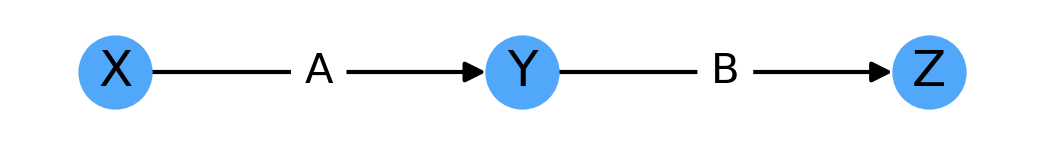

In [5]:
pos = {'X':(-1, 0), 'Y':(0, 0), 'Z':(1, 0)}
labels = {(node_i, node_j) : label for node_i, node_j, label in G.edges(data='label', default='')}

fig, ax = plt.subplots(1, figsize=(4,1))
nx.draw(G, pos, ax=ax, node_color=colors[0])
nx.draw_networkx_labels(G, pos, ax=ax)
nx.draw_networkx_edge_labels(G, pos, labels, ax=ax)
fig.tight_layout()

And if we add mode edges, the layout naturally needs to change as well

In [6]:
G = nx.DiGraph()
G.add_edges_from([
    ('X', 'Y'),
    ('X', 'W'),
    ('W', 'Y'),
    ('W', 'Z'),
    ('Y', 'T'),
    ('Y', 'Z'),
    ('Z', 'T')])

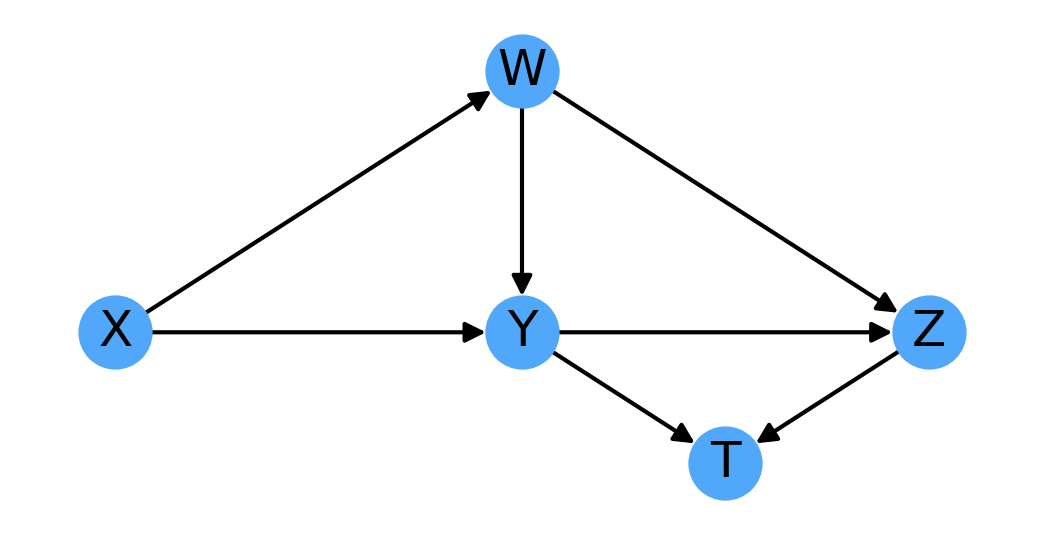

In [7]:
pos = {'X': (-1, 0), 'Y': (0, 0), 'Z': (1, 0), 'W': (0, 1), 'T' : (0.5, -0.5)}

fig, ax = plt.subplots(1, figsize=(4,2.3))
nx.draw(G, pos, ax=ax, node_color=colors[0])
nx.draw_networkx_labels(G, pos, ax=ax)
fig.tight_layout()

NetworkX also gives us simple ways to directly ask questions of this DAG

We can get the parents (predecessors) and ancestors of Z

In [8]:
print('Parents:', list(G.predecessors('Z')), 'Ancestors:', list(nx.ancestors(G, 'Z')))

Parents: ['W', 'Y'] Ancestors: ['Y', 'X', 'W']


And the children (successors) and decendents of W:

In [9]:
print('Children:', list(G.successors('W')), 'Descendants:', list(nx.descendants(G, 'W')))

Children: ['Y', 'Z'] Descendants: ['Y', 'T', 'Z']


We can easily find all the directed paths between X and T

In [10]:
directed_paths = {tuple(path) for path in nx.all_simple_paths(G, 'X', 'T')}

In [11]:
print(directed_paths)

{('X', 'Y', 'Z', 'T'), ('X', 'W', 'Y', 'T'), ('X', 'W', 'Z', 'T'), ('X', 'Y', 'T'), ('X', 'W', 'Y', 'Z', 'T')}


And write a helper function to plot them all out on top of our DAG:

In [12]:
def plot_path(G, pos, path, ax=None):
    fig = None
    
    if ax == None:
        fig, ax = plt.subplots(1, figsize=(4, 2.3))
    
    edgelist = {(path[i], path[i+1]) for i in range(len(path)-1)}
    edges = set(G.edges()) - set(edgelist)
    
    nx.draw(G, pos, node_color=colors[0], ax=ax, edgelist=[])
    nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos,
                       edgelist=edgelist,
                       width=3, edge_color=colors[1], ax=ax)
    nx.draw_networkx_edges(G, pos,
                       edgelist=edges,
                       width=1, ax=ax)
    if fig is not None:
        fig.tight_layout()

And easily plot them all side by side

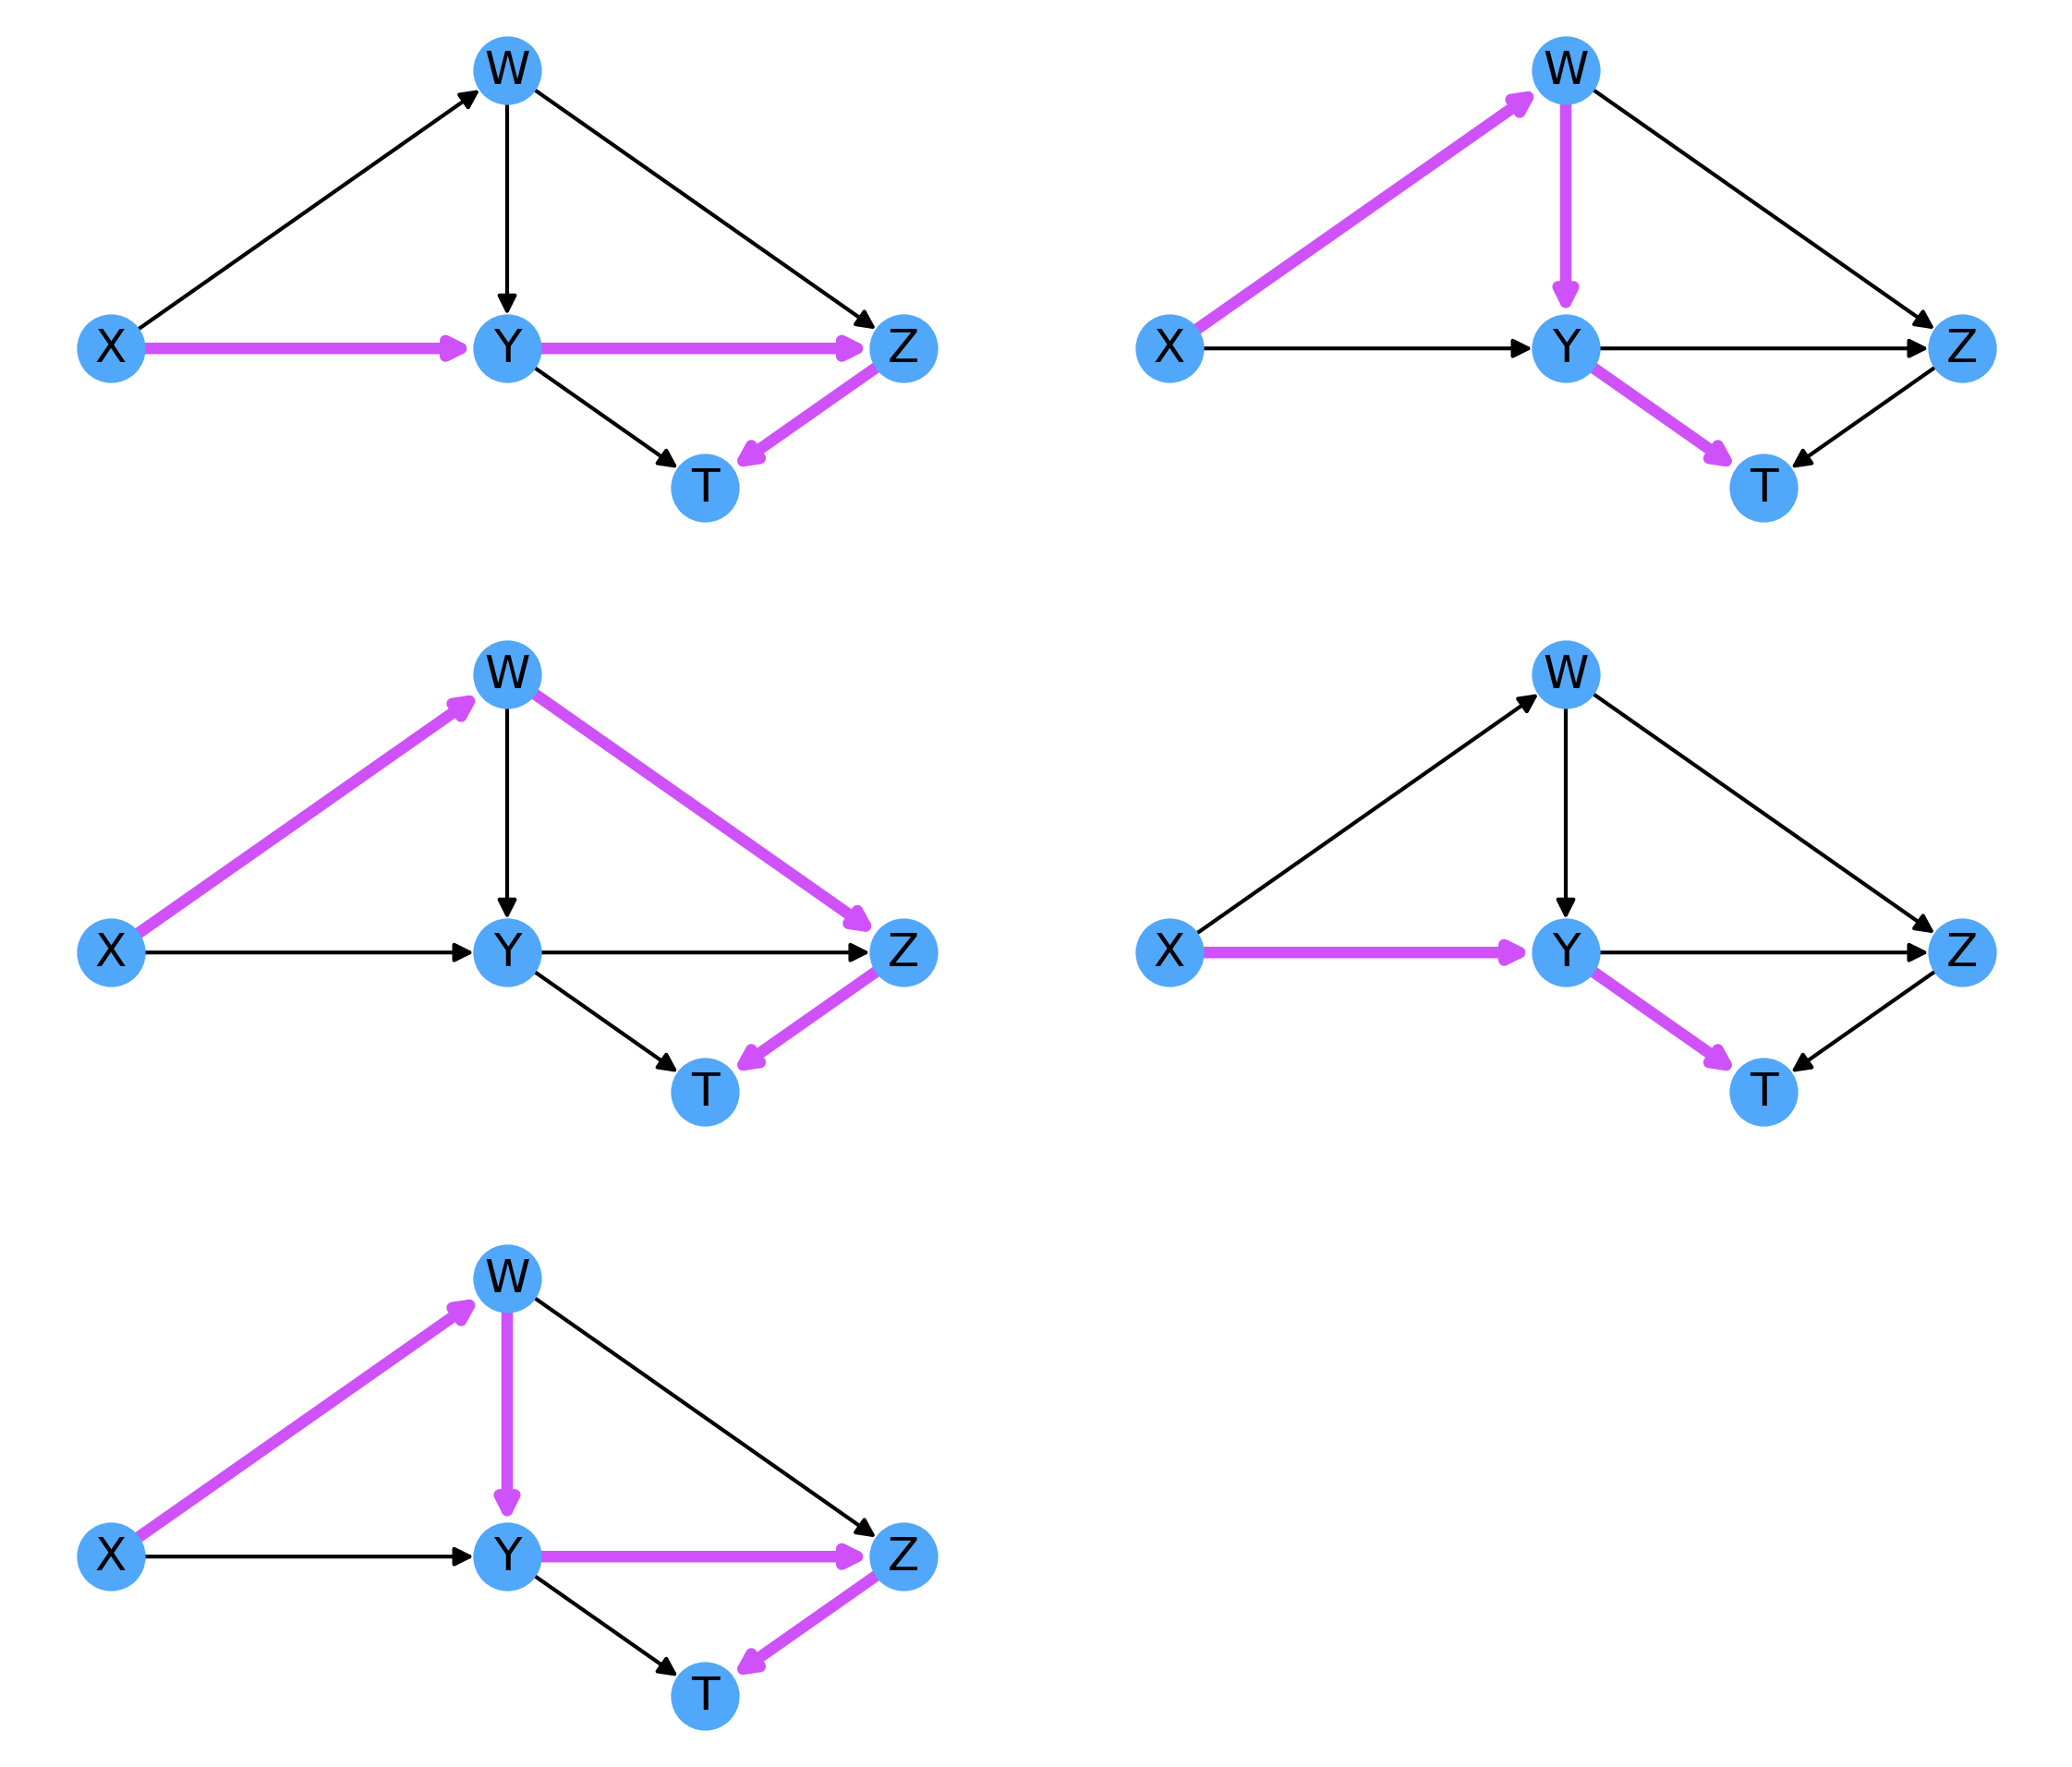

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(8, 6.9))
axs = np.array(axs).flatten()

for i, path in enumerate(directed_paths):
    plot_path(G, pos, path, axs[i])

axs[-1].axis('off')
fig.tight_layout()

In some cases, we're also interested in all the paths, even if they break the direction of the edges. We can extract them all by converting our __DiGraph__ into a regular __Graph__ before calling __nx.all_simple_paths__

In [14]:
all_paths = {tuple(path) for path in nx.all_simple_paths(nx.to_undirected(G), 'X', 'T')}

And we see that we find two extra paths

In [15]:
print(all_paths-directed_paths)

{('X', 'W', 'Z', 'Y', 'T'), ('X', 'Y', 'W', 'Z', 'T')}


That we can also visualize

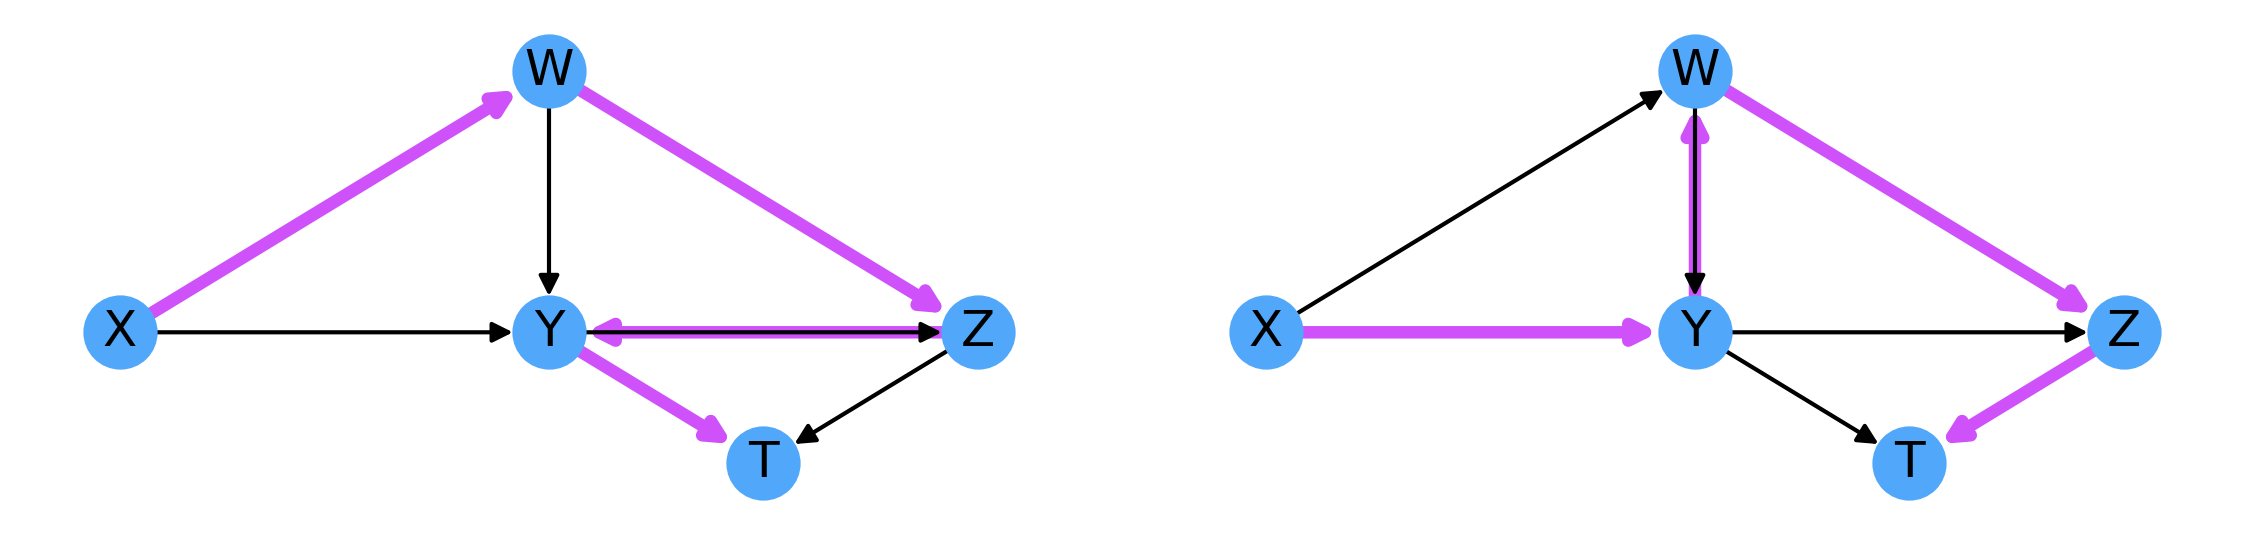

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.3))
axs = np.array(axs).flatten()

new_paths = all_paths-directed_paths

for i, path in enumerate(new_paths):
    plot_path(G, pos, path, axs[i])

axs[-1].axis('off')
fig.tight_layout()

## Modeling Causal Assumptions

For convenience, we abstracted away the NetworkX functions into the CausalModel class. We can load the structure of this model directly from disk:

In [17]:
G = CausalModel('dags/Primer.Fig.1.9.dot')

And plot it quickly

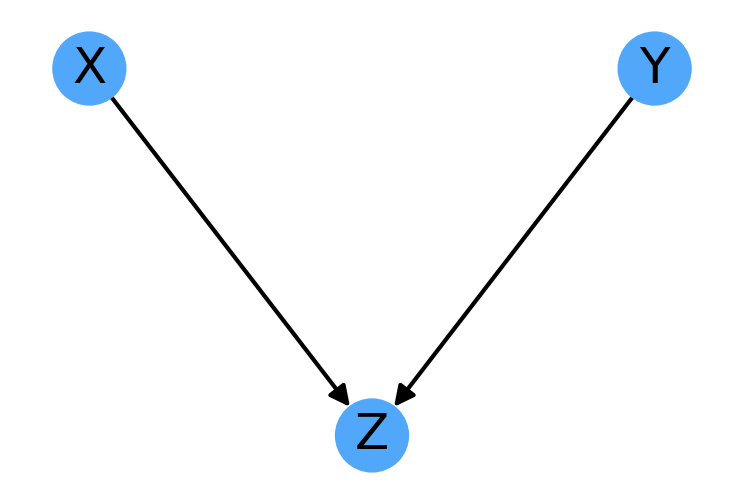

In [18]:
fig, ax = plt.subplots(1, figsize=(3, 2.2))
G.plot(ax=ax, legend=False)

We generate our fake data

In [19]:
x = np.linspace(20, 30)
y = np.linspace(100, 300, 50)
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()

Z = 2*X+3*Y

model = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

And inspect it:

In [20]:
model

,X,Y,Z
0,20.000000,100.0,340.000000
1,20.204082,100.0,340.408163
2,20.408163,100.0,340.816327
3,20.612245,100.0,341.224490
4,20.816327,100.0,341.632653
...,...,...,...
2495,29.183673,300.0,958.367347
2496,29.387755,300.0,958.775510
2497,29.591837,300.0,959.183673
2498,29.795918,300.0,959.591837


And to go the other way, we simply perform an OLS Linear Regression fit to estimate the dependency of Z as a function of X and Y

In [21]:
ols = smf.ols('Z ~ X + Y', model).fit()

From where we easily extract the coefficients of our model for $f_Z$

In [22]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.991e+30
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:01:02   Log-Likelihood:                 62959.
No. Observations:                2500   AIC:                        -1.259e+05
Df Residuals:                    2497   BIC:                        -1.259e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.012e-11   5.15e-13    -19.659      0.000   -1.11e-11   -9.11e-12
X              2.0000    1.9e-14   1.05e+14      0.000       2.000       2.000
Y              3.0000    9.5e-16   3.16e+15      0.000       3.000       3.000
==============================================================================
Omnibus:                     1971.543   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.925
Skew:                          -0.003   Prob(JB):                     4.58e-33
Kurtosis:                       1.804   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let us now build the model for SCM 1.5.3

In [23]:
G2 = CausalModel()
G2.add_causation(r'$U_X$', 'X')
G2.add_causation(r'$U_Y$', 'Y')
G2.add_causation(r'$U_Z$', 'Z')
G2.add_causation('X', 'Y')
G2.add_causation('Y', 'Z')
G2.pos = {r'$U_X$': (-1, 1), r'$U_Y$':(0,1), r'$U_Z$': (1,1), 'X': (-1, 0), 'Y':(0,0), 'Z':(1, 0)}

Visualize it

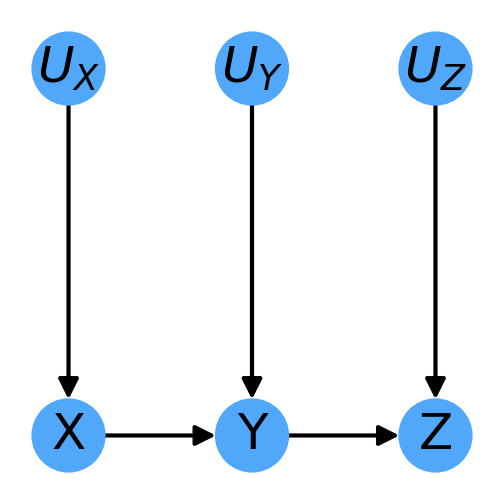

In [24]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G2.plot(ax=ax)

And save it as a dot file so that we can reuse it later on.

In [25]:
G2.save_model('dags/Primer.SCM.1.5.3.dot')

Since this is a stochastic model, we have to use random numbers. We'll assume that the exogenous variables are normally distributed and generate 100,000 values for each of them

In [26]:
N = 100_000
Ux = np.random.normal(size=N) 
Uy = np.random.normal(size=N)
Uz = np.random.normal(size=N)

And define the 3 functions that determine the values of X, Y and Z

In [27]:
fX = lambda ux: ux
fY = lambda x, uy: 1/3*x+uy
fZ = lambda y, uz: 1/16*y+uz

With these two ingredients at hand, we can easily build up the DataFrame that describes our model

In [28]:
X = fX(Ux)
Y = fY(X, Uy)
Z = fZ(Y, Uz)

model = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

And inspect it

In [29]:
model

,X,Y,Z
0,0.863273,-0.318378,1.088303
1,0.652127,1.387984,-1.011332
2,1.165002,0.417274,0.623555
3,-0.424229,-0.231184,0.081054
4,0.814281,-0.118311,0.979298
...,...,...,...
99995,0.853600,-0.206891,0.932264
99996,-0.055609,-0.611285,0.700521
99997,-0.510857,0.737662,0.995006
99998,-1.573281,-0.107842,-0.375497


If we observe that Y=3, then the expected (mean) value of Z is:

In [30]:
Z_Y3 = np.mean(fZ(3, Uz))
print(Z_Y3)

0.1913023663533399


Which is close to the analytically expected value of 3/16=0.1875

Another way of calculating this value would be through a direct fit using the numerical values in our DataFrame

In [31]:
ols = smf.ols('Z ~ Y', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     400.7
Date:                Wed, 26 Jan 2022   Prob (F-statistic):           5.93e-89
Time:                        14:01:02   Log-Likelihood:            -1.4197e+05
No. Observations:              100000   AIC:                         2.839e+05
Df Residuals:                   99998   BIC:                         2.840e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0038      0.003      1.200      0.230      -0.002       0.010
Y              0.0599      0.003     20.016      0.000       0.054       0.066
==============================================================================
Omnibus:                        1.495   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.489
Skew:                          -0.005   Prob(JB):                        0.475
Kurtosis:                       3.017   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
ols.predict({'Y': 3})

0    0.183497
dtype: float64

With the added advantage that this approach takes into account also the values of the exogenous (error) variables.

If, on the other hand, we observe that $X=3$ then our calculation requires 2 steps, as this information must *flow* from X to Y and finally to Z

In [33]:
Y_X3 = fY(3, Uy)
Z_X3 = np.mean(fZ(Y_X3, Uz))
print(Z_X3)

0.06611688177831905


Which again is close to the expected analytical value of 1/16=0.0625

Or a simple fit

In [34]:
ols = smf.ols('Z ~ X', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     40.11
Date:                Wed, 26 Jan 2022   Prob (F-statistic):           2.42e-10
Time:                        14:01:02   Log-Likelihood:            -1.4215e+05
No. Observations:              100000   AIC:                         2.843e+05
Df Residuals:                   99998   BIC:                         2.843e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0036      0.003      1.141      0.254      -0.003       0.010
X              0.0200      0.003      6.333      0.000       0.014       0.026
==============================================================================
Omnibus:                        1.789   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.786
Skew:                          -0.005   Prob(JB):                        0.409
Kurtosis:                       3.018   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
ols.predict({'X': 3})

0    0.063641
dtype: float64

We can also run the computation in the opposite direction (contrary to the direction of causality). If we want to know the expected value of $X$ given that $Y=2$. In this case we must fit a linear regression model to obtain a the dependency of X as a function of Y

In [36]:
ols = smf.ols('X ~ Y', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                 1.096e+04
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:01:03   Log-Likelihood:            -1.3704e+05
No. Observations:              100000   AIC:                         2.741e+05
Df Residuals:                   99998   BIC:                         2.741e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0028      0.003      0.925      0.355      -0.003       0.009
Y              0.2982      0.003    104.687      0.000       0.293       0.304
==============================================================================
Omnibus:                        1.283   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                1.286
Skew:                          -0.009   Prob(JB):                        0.526
Kurtosis:                       2.998   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
ols.predict({'Y': 2})

0    0.599236
dtype: float64

We can also use a similar approach to estimate the values of variables in the middle of a causal chain when we know the values before and after. For example, if we want to estimate the value of Y given that we observe specific values for X and Z, all we have to do is fit a linear model for Y as a function of X and Z

In [38]:
ols = smf.ols('Y ~ X + Z', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5680.
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:01:03   Log-Likelihood:            -1.4210e+05
No. Observations:              100000   AIC:                         2.842e+05
Df Residuals:                   99997   BIC:                         2.842e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0032      0.003     -1.004      0.316      -0.009       0.003
X              0.3300      0.003    104.474      0.000       0.324       0.336
Z              0.0600      0.003     18.984      0.000       0.054       0.066
==============================================================================
Omnibus:                        0.521   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.771   Jarque-Bera (JB):                0.522
Skew:                           0.006   Prob(JB):                        0.770
Kurtosis:                       2.999   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And now that we have a description of Y as a function X and Z, we can simply plugin the numbers

In [39]:
np.mean(ols.predict({'X':1, 'Z':3}))

0.5068437400249155

### Blocking variables.

An interesting point to make clear (and that we will delve into more deeply in Chapt 2) is that to determine the value of a given variable, we only need the know the values of it's parents. 

Let's say we observe that Y=3 and are interested in finding out the value of Z. We can simply do:

In [40]:
ols = smf.ols('Z ~ Y', model).fit()
ols.predict({'Y': 3})

0    0.183497
dtype: float64

On the other hand, let's say that we also observe that X=1. In this case, we would do:

In [41]:
ols = smf.ols('Z ~ Y + X', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     200.3
Date:                Wed, 26 Jan 2022   Prob (F-statistic):           1.49e-87
Time:                        14:01:03   Log-Likelihood:            -1.4197e+05
No. Observations:              100000   AIC:                         2.839e+05
Df Residuals:                   99997   BIC:                         2.840e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0038      0.003      1.199      0.230      -0.002       0.010
Y              0.0598      0.003     18.984      0.000       0.054       0.066
X              0.0002      0.003      0.056      0.955      -0.006       0.007
==============================================================================
Omnibus:                        1.495   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.489
Skew:                          -0.005   Prob(JB):                        0.475
Kurtosis:                       3.017   Cond. No.                         1.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
ols.predict({'Y': 3, 'X':1})

0    0.183516
dtype: float64

which returns the same result (up to numerical precision). While counterintuitive, this result is simple to understand. In our causal model, the value of Z is determined only by the value of Y. Once Y is determined, the factors that might have led to its value (a statistical fluctuation in Uy, or the value of X) are irrelevant. All that Z "sees" is the current value of Y and Y *shields* Z from everything that happened before in its causal chain

In this simple observation lies much of the power of this approach!

## Product Decomposition

In [43]:
G = CausalModel('dags/Primer.Fig.1.10.dot')

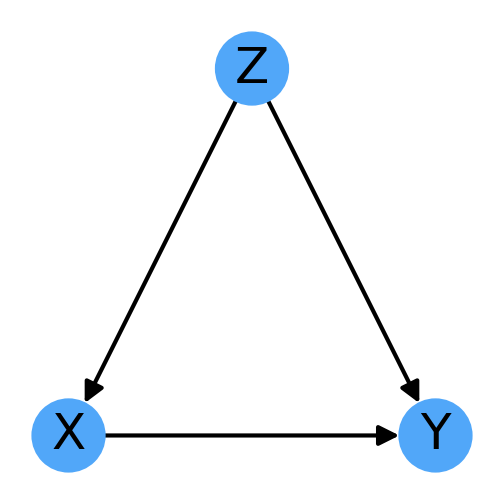

In [44]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G.plot(ax=ax)

In [45]:
PZ = pd.DataFrame({'Z': [0, 1], 'P(Z)': ['1-r', 'r']})

In [46]:
PZ

,Z,P(Z)
0,0,1-r
1,1,r


In [47]:
MedicationProb = pd.DataFrame({
    'X': [1, 1, 0, 0],
    'Z': [0, 1, 0, 1],
    ' P(X | Z)': [r'$q_{0}$', r'$q_{1}$', r'$1-q_0$', r'$1-q_{1}$']
})

In [48]:
MedicationProb

,X,Z,P(X | Z)
0,1,0,$q_{0}$
1,1,1,$q_{1}$
2,0,0,$1-q_0$
3,0,1,$1-q_{1}$


In [49]:
DeathProb = pd.DataFrame({
    'Y':[1, 1, 1, 1, 0, 0, 0, 0],
    'X':[1, 0, 0, 1, 1, 0, 0, 1],
    'Z':[0, 0, 1, 1, 0, 0, 1, 1],
    'P(Y | X,Z)':[r'$p_{10}$', r'$p_{00}$', r'$p_{01}$', r'$p_{11}$', r'$1-p_{10}$', r'$1-p_{00}$', r'$1-p_{01}$', r'$1-p_{11}$']})

In [50]:
DeathProb

,Y,X,Z,"P(Y | X,Z)"
0,1,1,0,$p_{10}$
1,1,0,0,$p_{00}$
2,1,0,1,$p_{01}$
3,1,1,1,$p_{11}$
4,0,1,0,$1-p_{10}$
5,0,0,0,$1-p_{00}$
6,0,0,1,$1-p_{01}$
7,0,1,1,$1-p_{11}$


## Chains

In [51]:
G = CausalModel()
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uz', 'Z')
G.add_causation('X', 'Y')
G.add_causation('Y', 'Z')

G.pos = {'X': (0, 1), 'Y': (0, 0), 'Z':(0, -1), 'Ux':(-.5, 1.5), 'Uy':(-.5, .5), 'Uz': (-.5,-.5)}

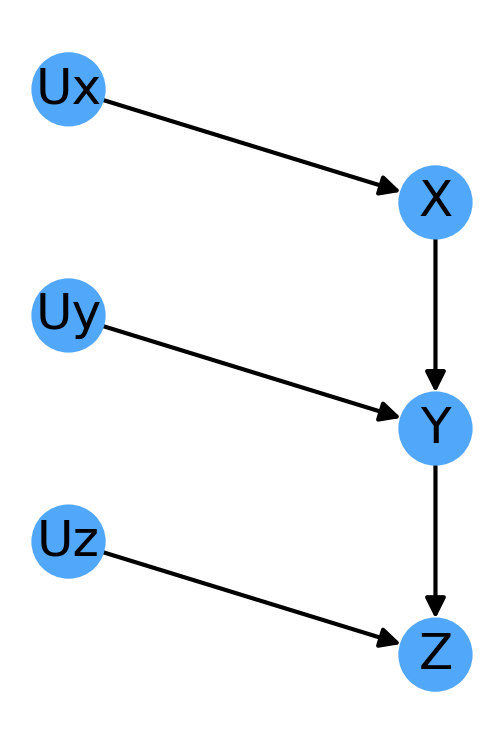

In [52]:
fig, ax = plt.subplots(1, figsize=(2.2, 3))
G.plot(ax=ax)

In [53]:
G.save_model('dags/Primer.Fig.2.1.dot')

## Forks

In [54]:
G = CausalModel()
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uz', 'Z')
G.add_causation('X', 'Y')
G.add_causation('X', 'Z')

G.pos = {'X': (0, 1), 'Y': (-1, 0), 'Z':(1, 0), 'Ux':(0, 2), 'Uy':(-1, 1), 'Uz': (1,1)}

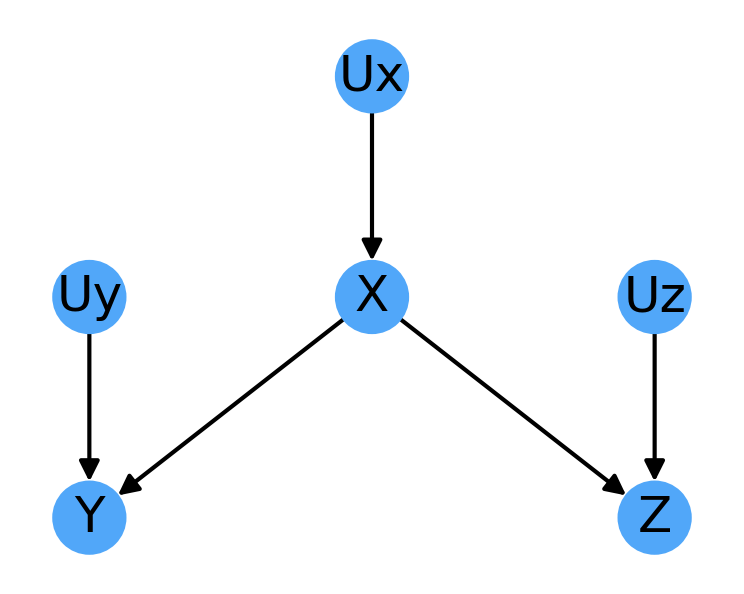

In [55]:
fig, ax = plt.subplots(1, figsize=(3, 2.5))
G.plot(ax=ax)

In [56]:
G.save_model('dags/Primer.Fig.2.2.dot')

## Colliders

In [57]:
G = CausalModel()
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uz', 'Z')
G.add_causation('X', 'Z')
G.add_causation('Y', 'Z')

G.pos = {'X': (-1, 0), 'Y': (1, 0), 'Z':(0, -1), 'Ux':(-1, 1), 'Uy':(1, 1), 'Uz': (0, 0)}

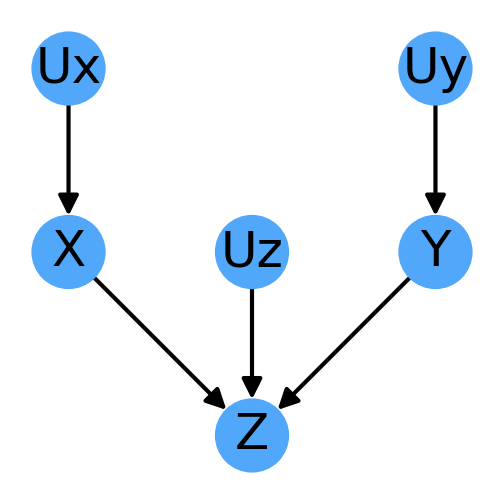

In [58]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G.plot(ax=ax)

In [59]:
G.save_model('dags/Primer.Fig.2.3.dot')

### Conditioning

Text(8, 10, '$Z=X+Y$')

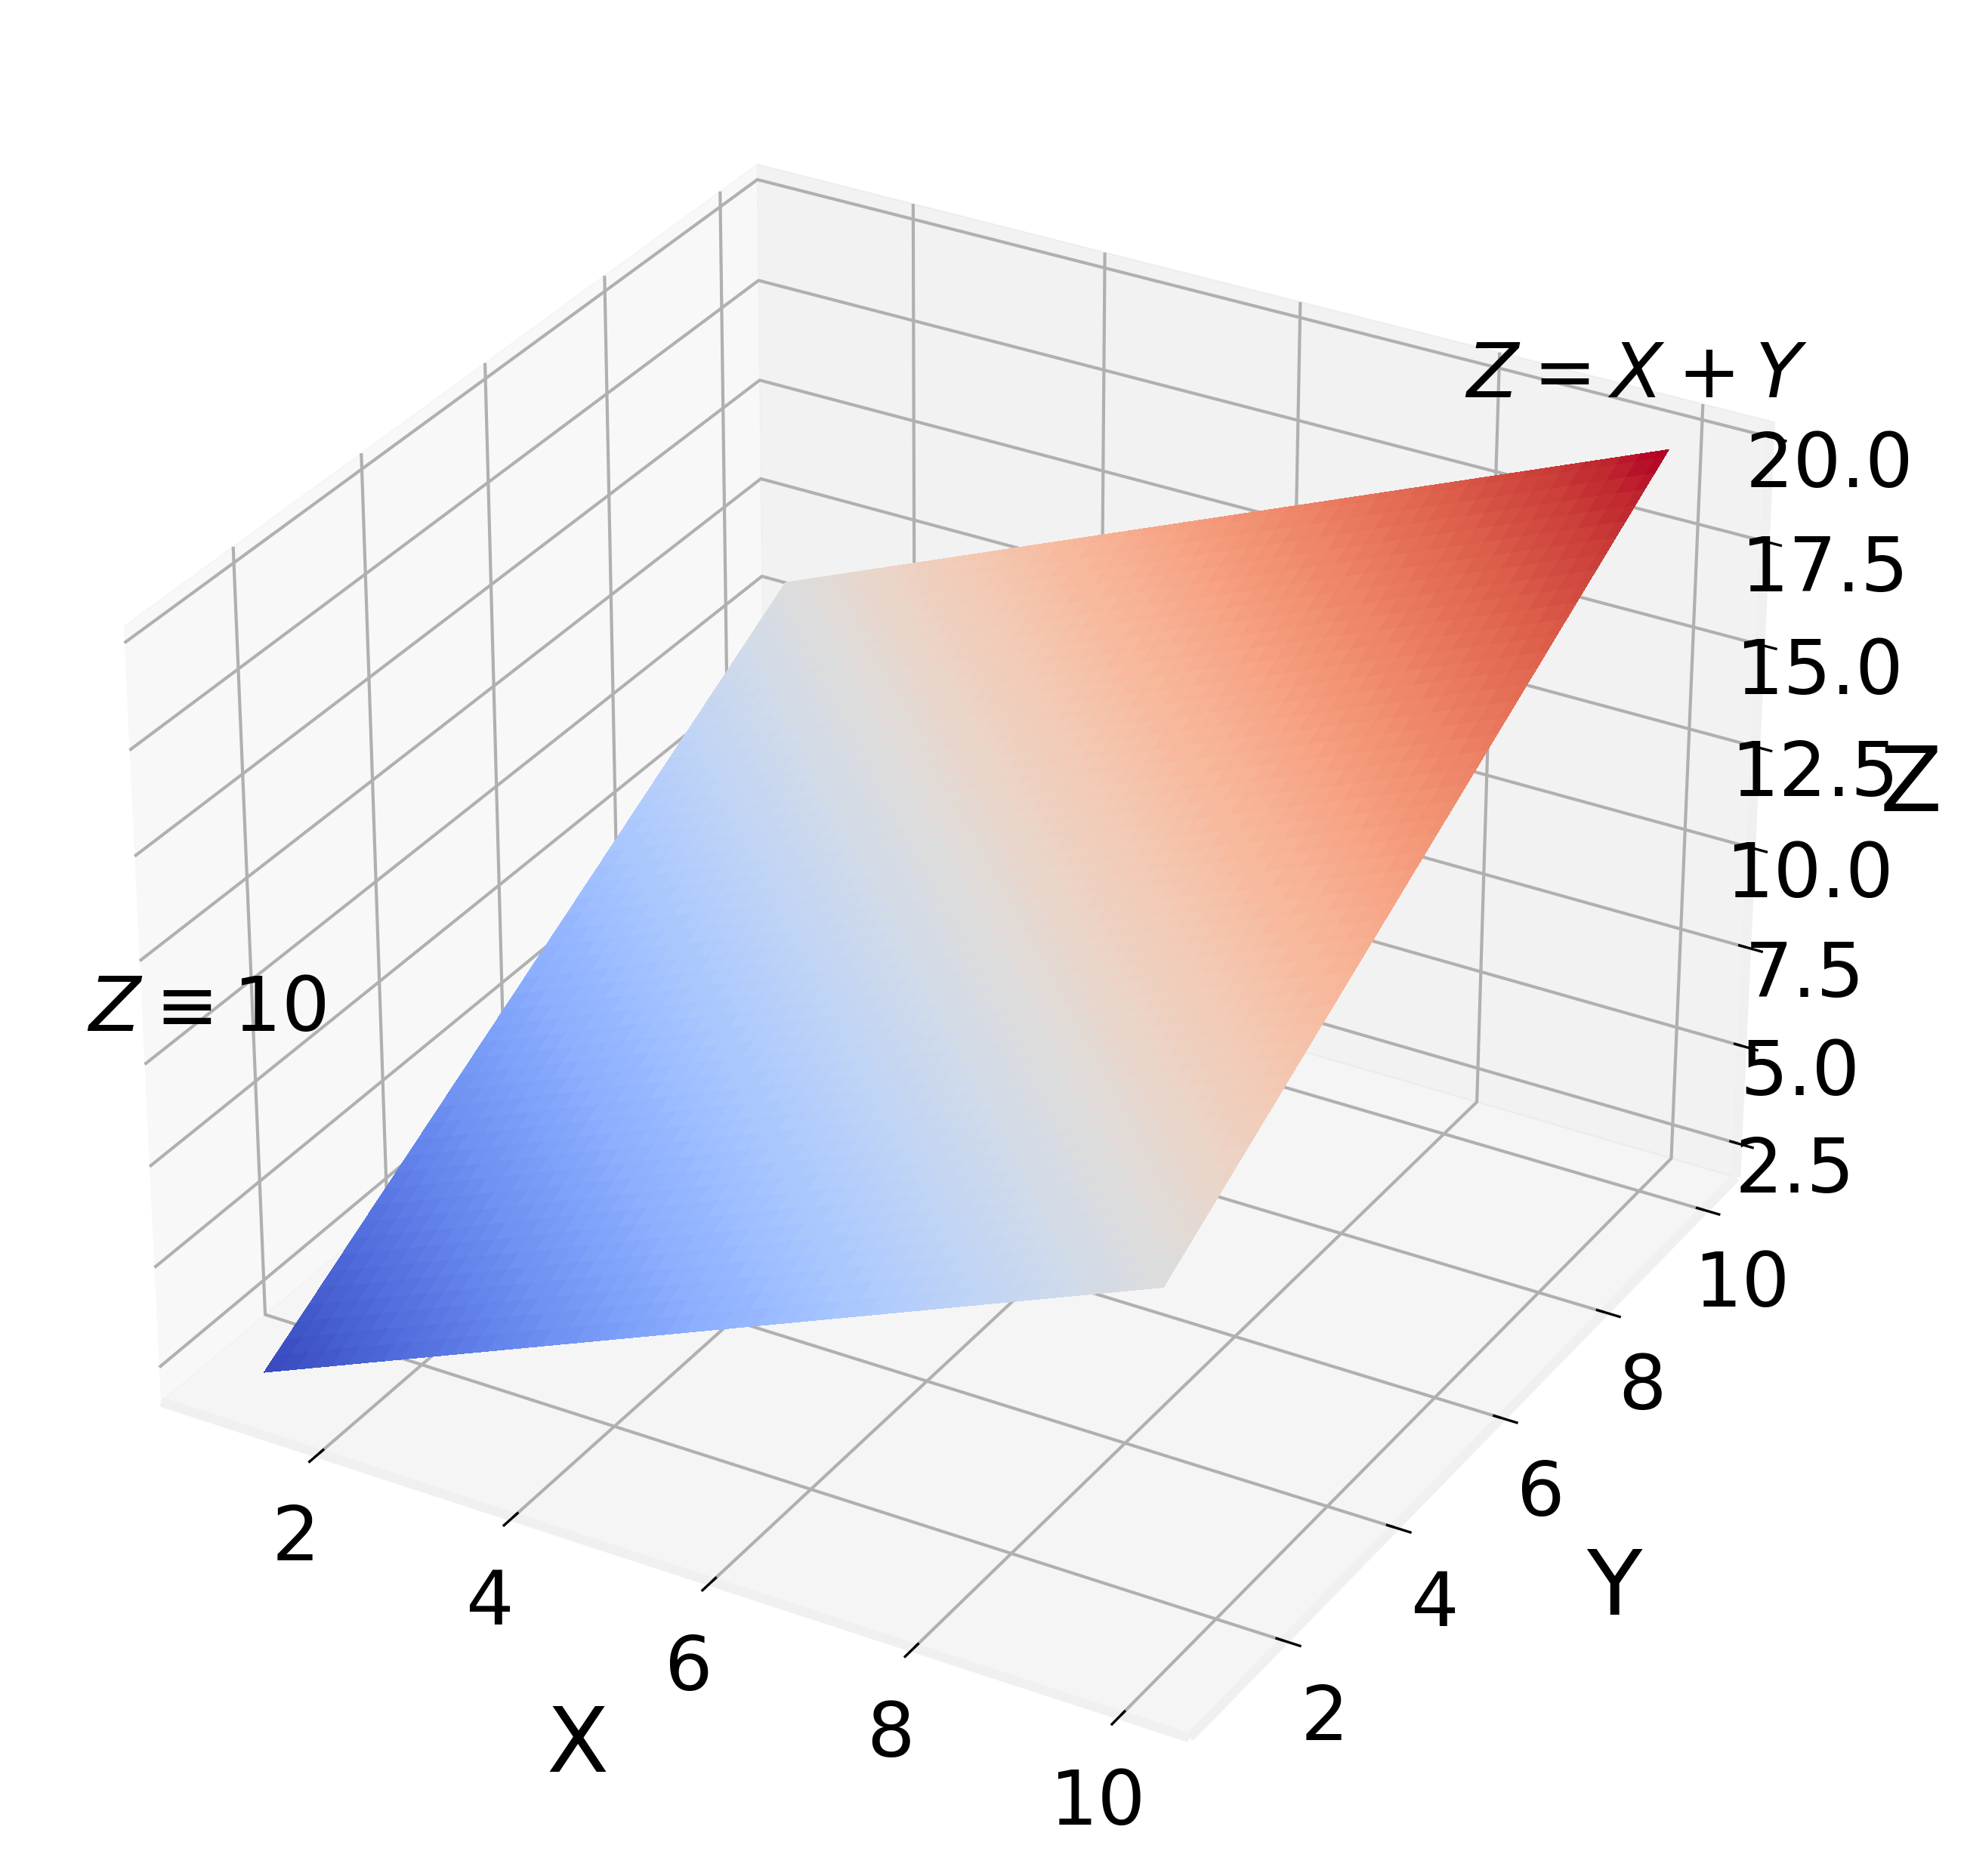

In [60]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Model data generation
X = np.linspace(1, 10, 100)
Y = np.linspace(1, 10, 100)
X, Y = np.meshgrid(X, Y)
Z = X+Y
Z10 = Z*0+10

# Workaround for how matploltib works in 3D. 
# We plot both sides of the surface separately.
X2 = np.linspace(1, 10, 100)
Y2 = np.linspace(1, 10, 100)
X2, Y2 = np.meshgrid(X2, Y2)
Z102 = Z*0+10

X2[Z<=10] = np.nan
Y2[Z<=10] = np.nan
Z102[Z<=10] = np.nan

ax.plot_surface(X2, Y2, Z102, cmap=cm.coolwarm, antialiased=False)
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)

X3 = np.linspace(1, 10, 100)
Y3 = np.linspace(1, 10, 100)
X3, Y3 = np.meshgrid(X3, Y3)
Z103 = Z*0+10

X3[Z>10] = np.nan
Y3[Z>10] = np.nan
Z103[Z>10] = np.nan
ax.plot_surface(X3, Y3, Z103, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel('X', labelpad=20)
ax.set_ylabel('Y', labelpad=20)
ax.set_zlabel('Z', labelpad=10)

ax.text(0, 0, 11, r'$Z\equiv 10$')
ax.text(8, 10, 20, r'$Z=X+Y$')

### Monty Hall

Write out all the possibilities in a Data Frame

In [61]:
Monty = pd.DataFrame({'Car':   ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C'], 
                      'Choice':['A', 'A', 'B', 'C', 'A', 'B', 'B', 'C', 'A', 'B', 'C', 'C'],
                      'Monty': ['B', 'C', 'C', 'B', 'C', 'A', 'C', 'A', 'B', 'A', 'A', 'B'],
                      'P': np.array([.5, .5, 1, 1, 1, .5, .5, 1, 1, 1, .5, .5])/9})

In [62]:
Monty

,Car,Choice,Monty,P
0,A,A,B,0.055556
1,A,A,C,0.055556
2,A,B,C,0.111111
3,A,C,B,0.111111
4,B,A,C,0.111111
5,B,B,A,0.055556
6,B,B,C,0.055556
7,B,C,A,0.111111
8,C,A,B,0.111111
9,C,B,A,0.111111


Verify that the car is equally likely to be in any door

In [63]:
Unconditional = Monty[['Car', 'Choice', 'P']].groupby(['Car', 'Choice']).sum().reset_index()
Unconditional['P'] = Unconditional.groupby(['Car']).apply(lambda x:x['P']/x['P'].sum()).values

In [64]:
Unconditional.set_index('Car')

,Choice,P
Car,,
A,A,0.333333
A,B,0.333333
A,C,0.333333
B,A,0.333333
B,B,0.333333
B,C,0.333333
C,A,0.333333
C,B,0.333333
C,C,0.333333


In [65]:
Conditional = Monty[['Monty', 'Car', 'Choice', 'P']].groupby('Monty').apply(lambda x:x[['Car', 'Choice', 'P']]
    .groupby(['Car', 'Choice']).sum()).reset_index()

In [66]:
Conditional['P'] = Conditional.groupby(['Monty', 'Car']).apply(lambda x:x['P']/x['P'].sum()).values

In [67]:
Conditional.set_index(['Monty', 'Car'])

Choice         P
Monty Car                 
A     B        B  0.333333
      B        C  0.666667
      C        B  0.666667
      C        C  0.333333
B     A        A  0.333333
      A        C  0.666667
      C        A  0.666667
      C        C  0.333333
C     A        A  0.333333
      A        B  0.666667
      B        A  0.666667
      B        B  0.333333

The probability of winning on the first try is 1/3

In [68]:
Monty['Win'] = (Monty['Choice'] == Monty['Car'])

In [69]:
Monty[['Win', 'P']].groupby('Win').sum()

,P
Win,
False,0.666667
True,0.333333


Independent of what my actual choice is

In [70]:
Choice_win = Monty[['Choice', 'Win', 'P']].groupby(['Choice', 'Win'], as_index=False).sum()
Choice_win['P'] = Choice_win.groupby('Choice').apply(lambda x:x['P']/x['P'].sum()).values

In [71]:
Choice_win

,Choice,Win,P
0,A,False,0.666667
1,A,True,0.333333
2,B,False,0.666667
3,B,True,0.333333
4,C,False,0.666667
5,C,True,0.333333


Calculate the joint probability table

In [72]:
Change_win = pd.concat([Monty, Monty], ignore_index=True)
Change_win['P']/=2

In [73]:
Change_win['Change']=False
Change_win['Change'].iloc[12:]=True
Change_win['Win'].iloc[12:] = ~Change_win['Win'].iloc[12:] 

In [74]:
Change_win

,Car,Choice,Monty,P,Win,Change
0,A,A,B,0.027778,True,False
1,A,A,C,0.027778,True,False
2,A,B,C,0.055556,False,False
3,A,C,B,0.055556,False,False
4,B,A,C,0.055556,False,False
5,B,B,A,0.027778,True,False
6,B,B,C,0.027778,True,False
7,B,C,A,0.055556,False,False
8,C,A,B,0.055556,False,False
9,C,B,A,0.055556,False,False


If you change your choice, the probability of winning is 2/3

In [75]:
Change_win = Change_win[['Choice', 'Change', 'Win', 'P']].groupby(['Choice', 'Change', 'Win'], as_index=False).sum()
Change_win['P'] = Change_win.groupby(['Choice', 'Change']).apply(lambda x:x['P']/x['P'].sum()).values

In [76]:
Change_win

,Choice,Change,Win,P
0,A,False,False,0.666667
1,A,False,True,0.333333
2,A,True,False,0.333333
3,A,True,True,0.666667
4,B,False,False,0.666667
5,B,False,True,0.333333
6,B,True,False,0.333333
7,B,True,True,0.666667
8,C,False,False,0.666667
9,C,False,True,0.333333


In [77]:
pd.pivot_table(Change_win[Change_win['Win']==True], index='Choice', columns='Change', values='P')[[1, 0]]

Change,True,False
Choice,,
A,0.666667,0.333333
B,0.666667,0.333333
C,0.666667,0.333333


## d-separation

In [78]:
fig25 = CausalModel()
fig25.load_model('dags/Primer.Fig.2.5.dot')

In [79]:
nodes = fig25.dag.nodes

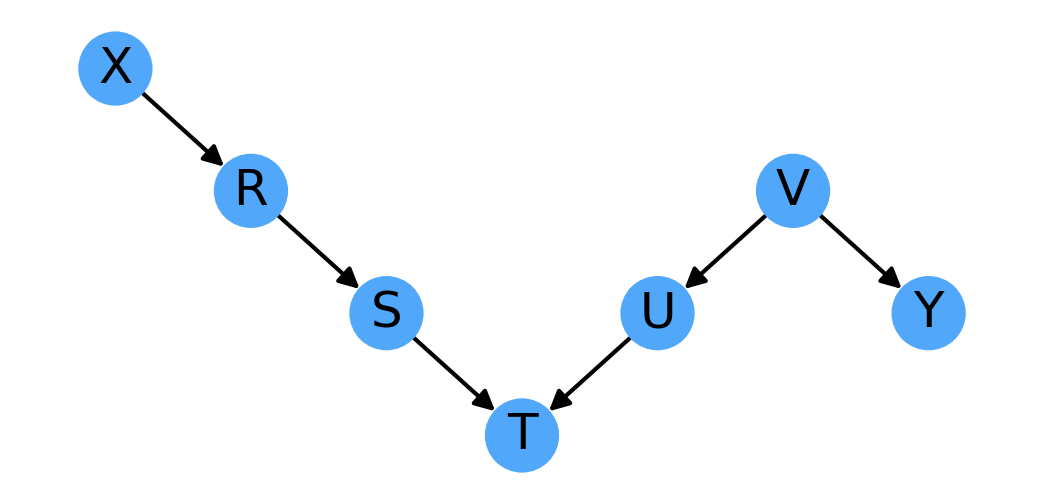

In [80]:
fig, ax = plt.subplots(1, figsize=(4, 2.2))
fig25.pos = {'X': (0, 0), 'R': (1, -1), 'S':(2, -2), 'T':(3, -3), 'U':(4, -2), 'V':(5, -1), 'Y': (6, -2)}
fig25.plot(ax=ax)

### Model Simulation

In [81]:
N = 100_000
df = pd.DataFrame({'X': np.random.normal(0, 1, N)})
df['V'] = np.random.normal(0, 1, N)

df['R'] = df['X'] + np.random.normal(0, .1, N)
df['S'] = df['R'] + np.random.normal(0, .1, N)
df['Y'] = df['V'] + np.random.normal(0, .1, N)
df['U'] = df['V'] + np.random.normal(0, .1, N)

df['T'] = np.sqrt(0.5)*df['S'] + np.sqrt(0.5)*df['U'] + np.random.normal(0, .1, N)

In [82]:
df

,X,V,R,S,Y,U,T
0,-0.158359,0.639107,-0.235451,-0.349880,0.518931,0.905084,0.428410
1,-0.406014,-0.284368,-0.336900,-0.422724,-0.270488,-0.198343,-0.266225
2,-0.952413,-1.076351,-0.999965,-1.015659,-1.203273,-1.214496,-1.501034
3,0.378447,2.224376,0.468317,0.462709,2.238815,2.087908,1.663580
4,1.001204,-0.116825,0.841575,0.723150,-0.090635,-0.117669,0.387156
...,...,...,...,...,...,...,...
99995,-0.043180,0.408809,-0.133141,-0.164298,0.507728,0.267673,0.064534
99996,0.260480,-0.967175,0.541946,0.547705,-1.118784,-1.008494,-0.315612
99997,0.235730,1.490417,0.315373,0.126801,1.479507,1.380173,1.029265
99998,-1.287250,-0.026700,-1.424841,-1.425754,-0.037610,-0.108628,-1.194063


Regress all pairs of variables conditional on R and V

In [83]:
remove = set(['R', 'V'])

formula = '%s ~ 1 + %s + ' + ' + '.join(remove)
print(formula)
summary = {}

for node_i, node_j in combinations(nodes, 2):    
    if len(set([node_i, node_j]) & remove) > 0:
        continue
    
    fml = formula % (node_i, node_j)
    print(node_i, node_j, '-->', fml)

    results = smf.ols(fml, df).fit()
    summary[(node_i, node_j)] = list(results.conf_int().loc[node_j].values)
    summary[(node_i, node_j)].append(results.params[node_j])
    summary[(node_i, node_j)].append(results.pvalues[node_j])

%s ~ 1 + %s + R + V
X S --> X ~ 1 + S + R + V
X T --> X ~ 1 + T + R + V
X U --> X ~ 1 + U + R + V
X Y --> X ~ 1 + Y + R + V
S T --> S ~ 1 + T + R + V
S U --> S ~ 1 + U + R + V
S Y --> S ~ 1 + Y + R + V
T U --> T ~ 1 + U + R + V
T Y --> T ~ 1 + Y + R + V
U Y --> U ~ 1 + Y + R + V


### Visualize the coefficients for each pair of variables

In [84]:
summary = pd.DataFrame(summary).T

In [85]:
summary

0         1         2         3
X S -0.002490  0.009910  0.003710  0.240823
  T -0.003841  0.004914  0.000537  0.810069
  U -0.005599  0.006777  0.000589  0.852015
  Y -0.006600  0.005731 -0.000434  0.890164
S T  0.348356  0.355943  0.352149  0.000000
  U -0.005507  0.006866  0.000680  0.829479
  Y -0.007047  0.005282 -0.000883  0.778960
T U  0.701108  0.716270  0.708689  0.000000
  Y -0.007875  0.009585  0.000855  0.847795
U Y -0.008811  0.003540 -0.002636  0.402905

In [86]:
def plot_coefficients(summary):
    fig, ax = plt.subplots(1)
    ax.axvline(x=0, c='darkgray', linestyle=':', linewidth=2)

    ax.vlines(ymin=np.arange(summary.shape[0])-.2, ymax=np.arange(summary.shape[0])+.2, x=summary[2], lw=2, color=colors[1])
    ax.hlines(y=np.arange(summary.shape[0]), xmin=summary[0], xmax=summary[1], lw=2, color=colors[1])
    
    ax.set_yticks(np.arange(summary.shape[0]))
    ax.set_yticklabels([r'$r_{%s%s}$' % (node_i, node_j) for node_i, node_j in summary.index])
    ax.set_xlabel('Coeffient estimate')
    ax.set_ylabel('Variable Pair Coefficient')
    ax.grid(linewidth=.5)

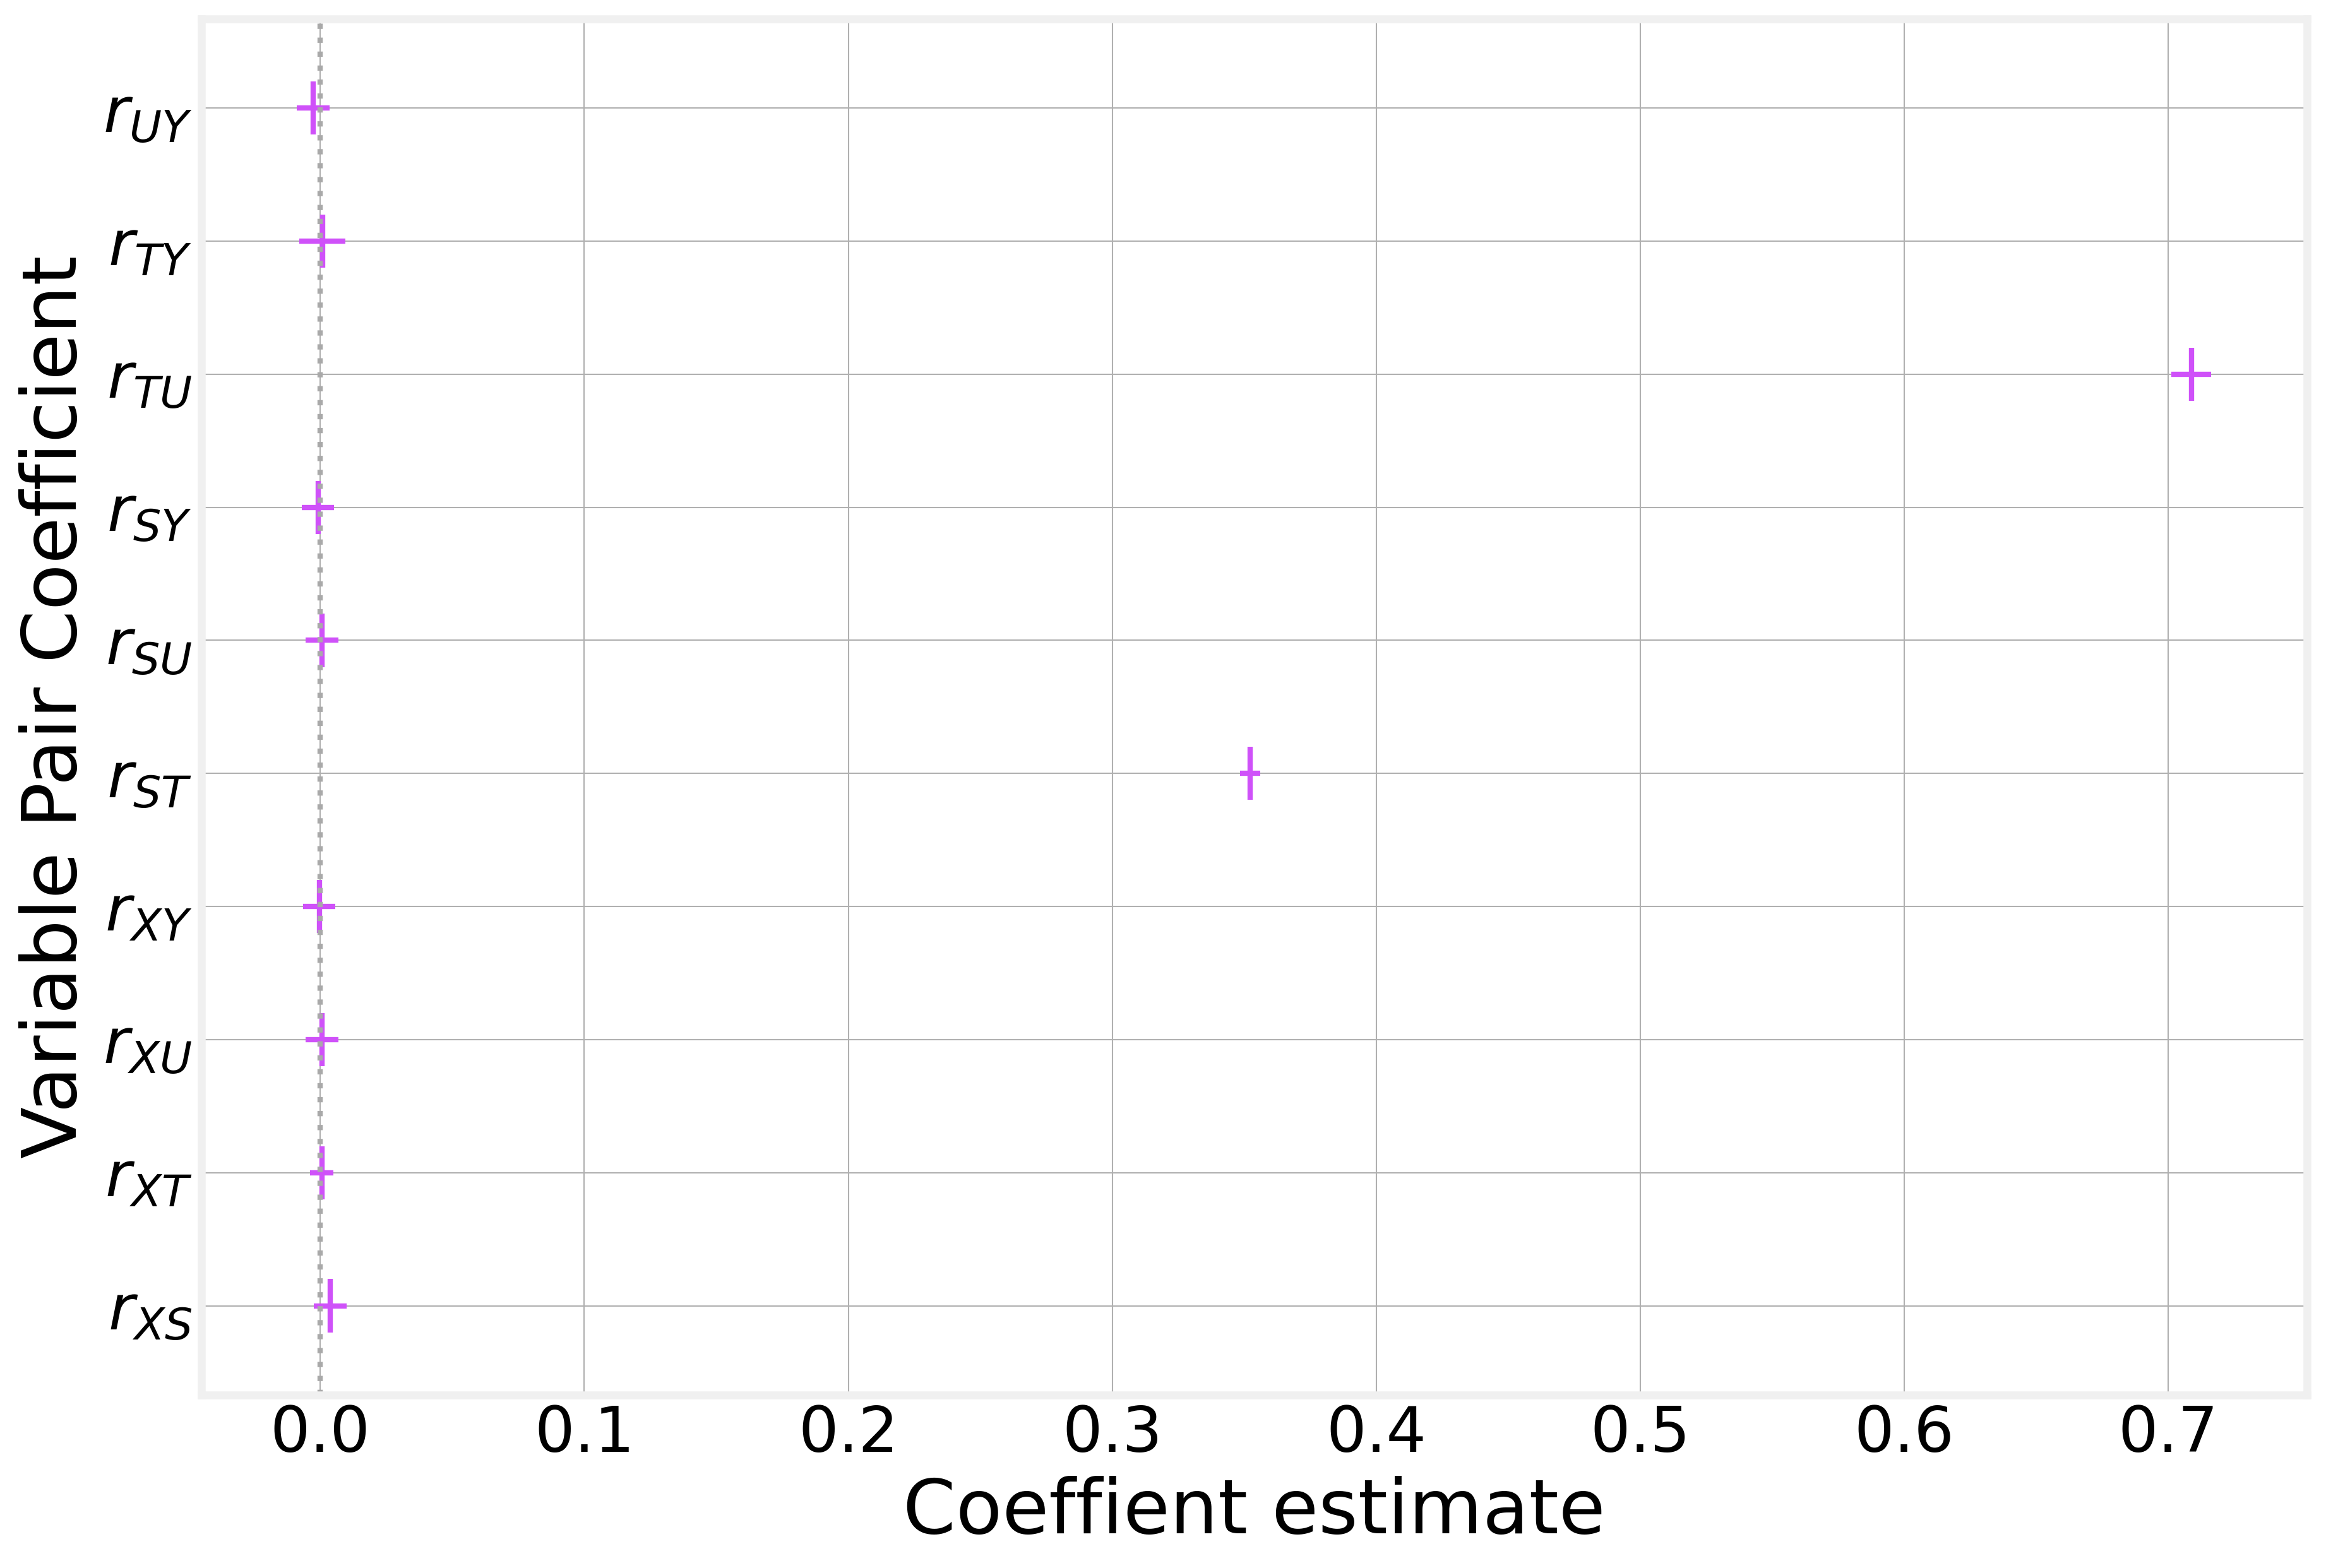

In [87]:
plot_coefficients(summary)

## d-separation

In [88]:
G = CausalModel()
G.add_causation('Uz', 'Z')
G.add_causation('Uw', 'W')
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uu', 'U')
G.add_causation('Z', 'W')
G.add_causation('X', 'W')
G.add_causation('X', 'Y')
G.add_causation('W', 'U')

G.pos = {'Uz':(-1, 1.5), 'Z':(-1, 1), 'W':(0, 0), 'Uw': (0, 0.5), 
         'X': (1, 1), 'Ux':(1, 1.5), 'Y':(2, 1), 'Uy':(2, 1.5),
         'U': (0, -1), 'Uu':(-0.5, -0.5)}

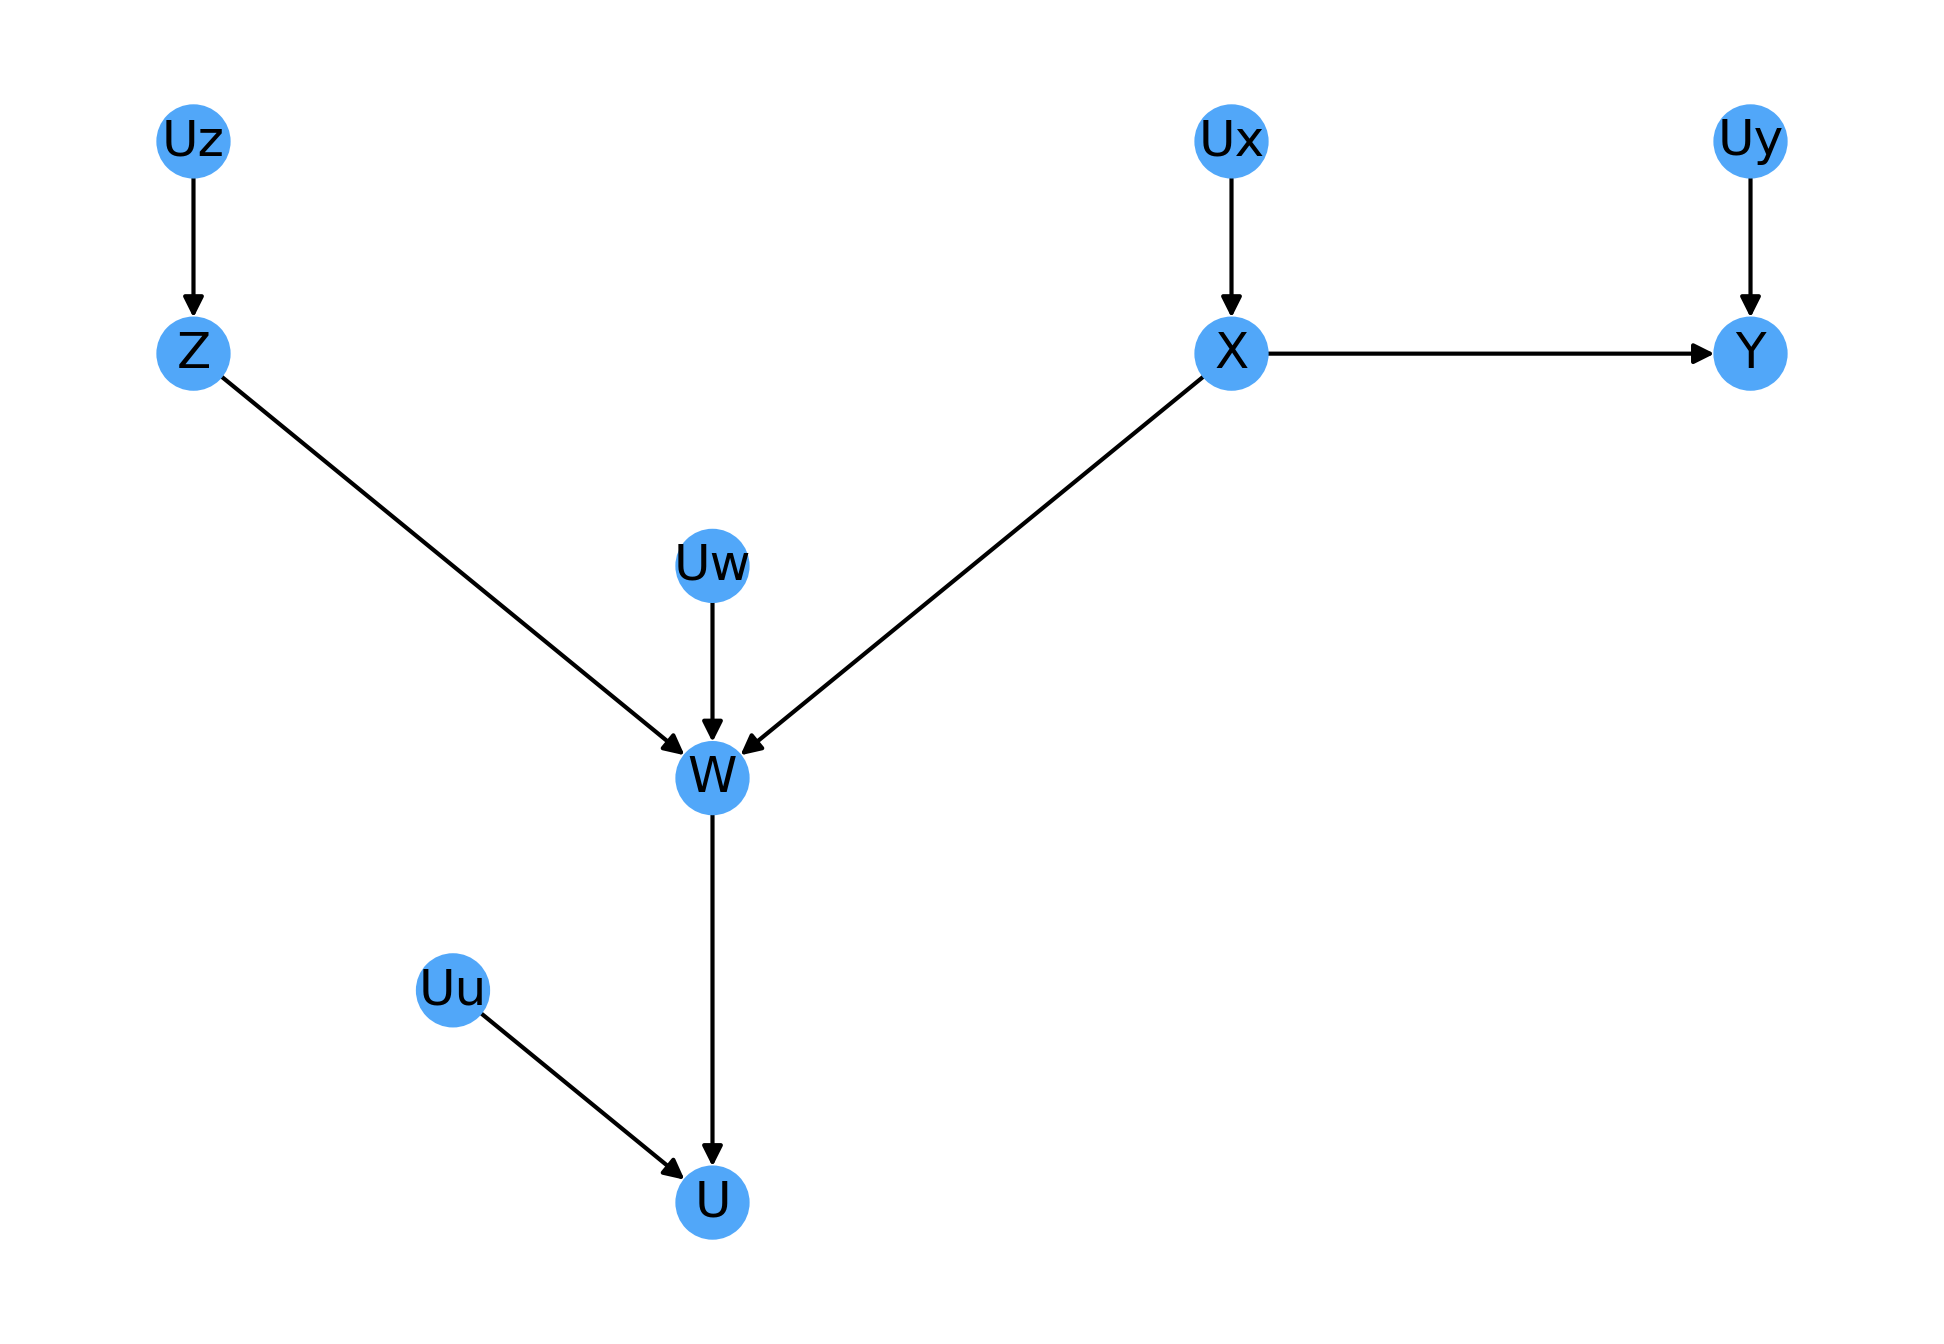

In [89]:
fig, ax = plt.subplots(1, figsize=(7, 5))
G.plot(ax=ax)

In [90]:
G.save_model('dags/Primer.Fig.2.7.dot')

This graph has only one path connecting Z and Y

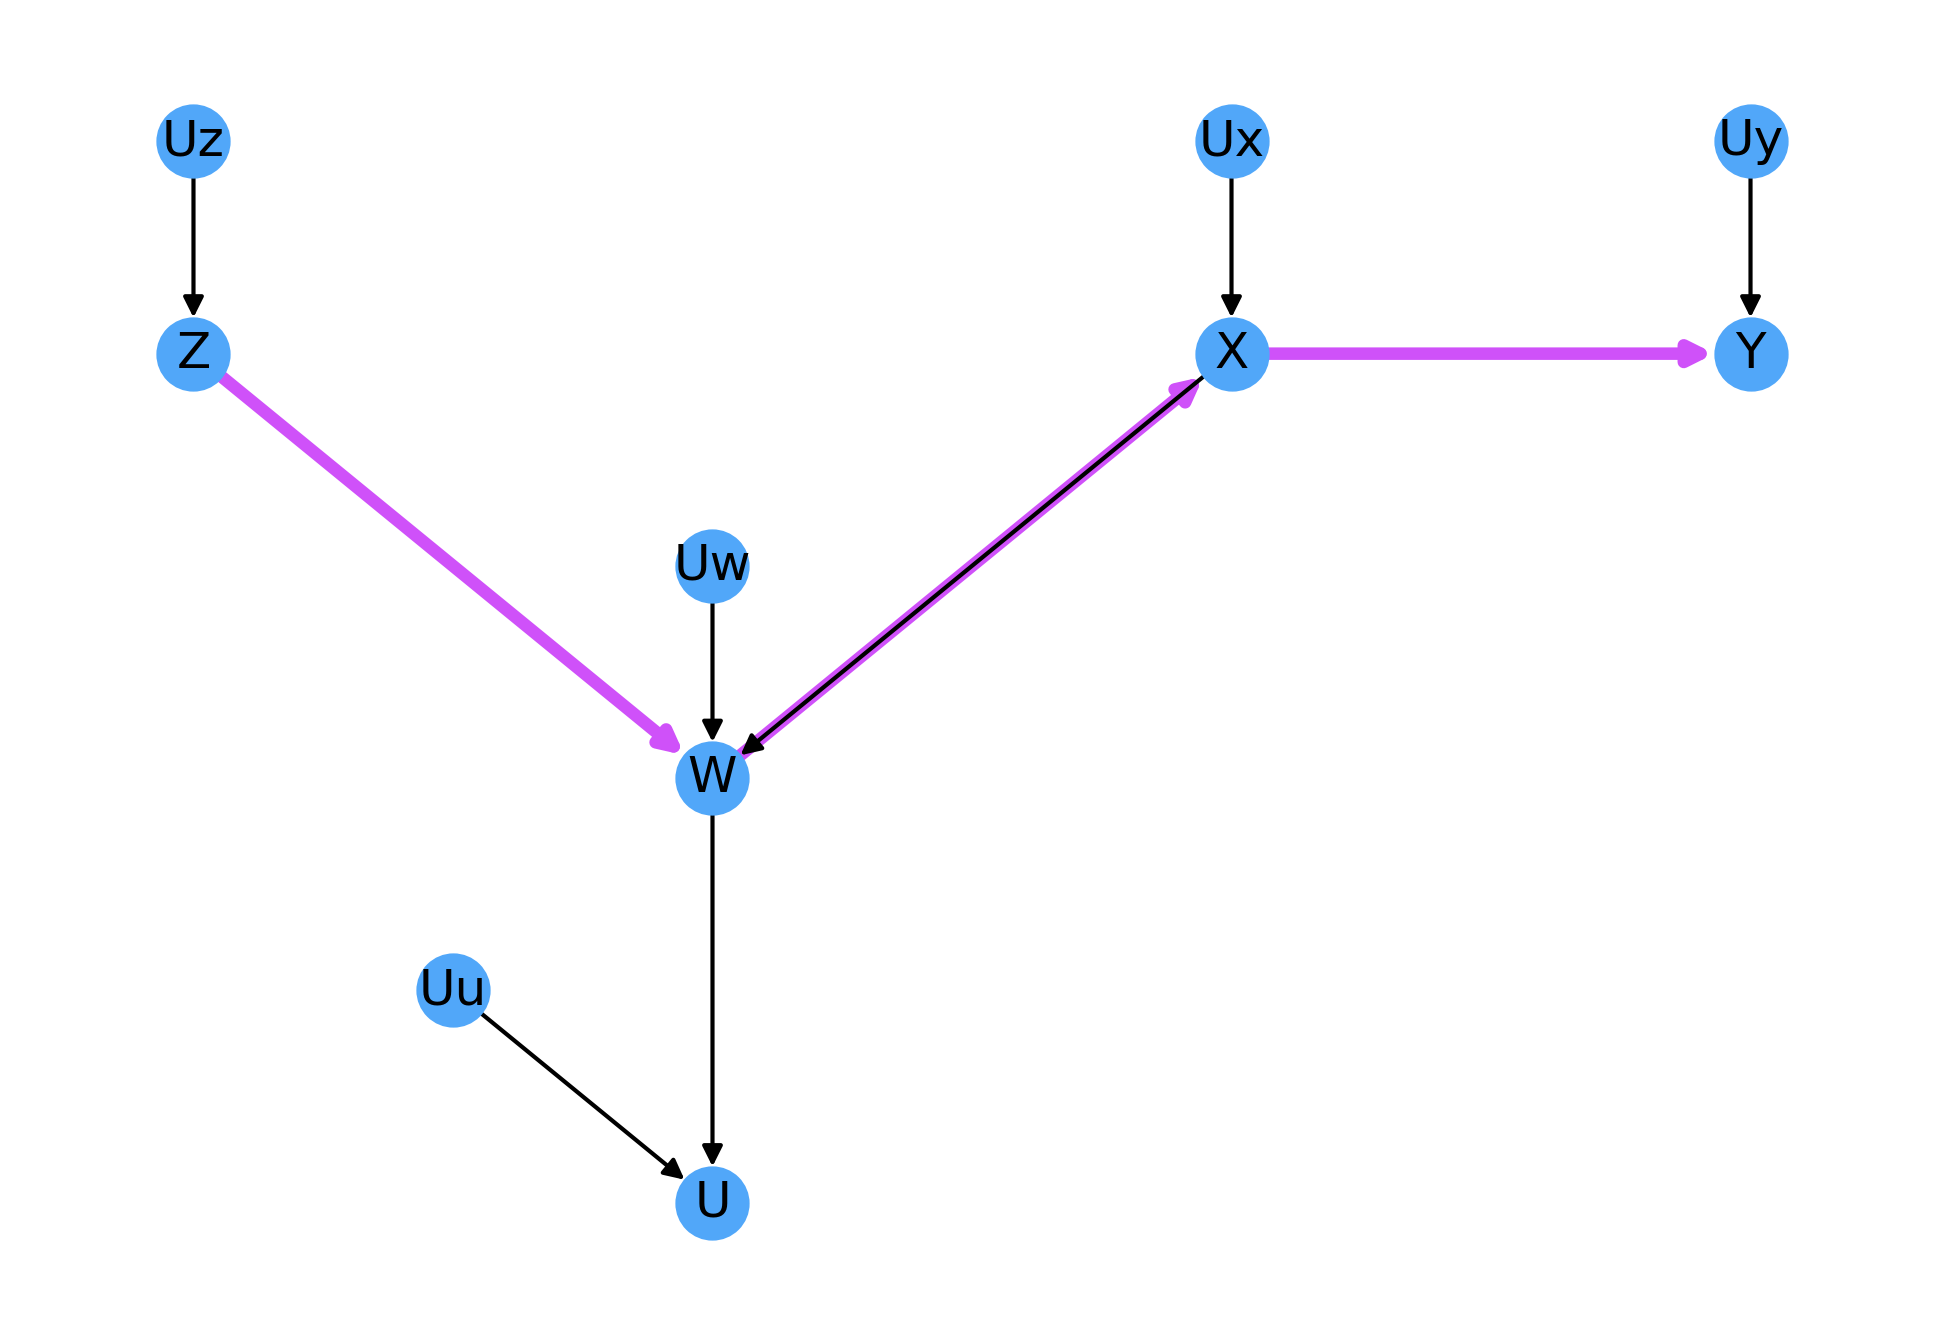

In [91]:
fig, ax_lst = plt.subplots(1, figsize=(7, 5))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(list(G.all_paths('Z', 'Y'))):
    G.plot_path(path, ax=ax_lst[i])

fig.tight_layout()

If we add a second path between Z and Y, we obtain:

In [92]:
G = CausalModel()
G.add_causation('Uz', 'Z')
G.add_causation('Uw', 'W')
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uu', 'U')
G.add_causation('Ut', 'T')
G.add_causation('Z', 'W')
G.add_causation('X', 'W')
G.add_causation('X', 'Y')
G.add_causation('W', 'U')
G.add_causation('T', 'Z')
G.add_causation('T', 'Y')

G.pos = {'Uz':(-1, 1.5), 'Z':(-1, 1), 'W':(0, 0), 'Uw': (0, 0.5), 
         'X': (1, 1), 'Ux':(1, 1.5), 'Y':(2, 1), 'Uy':(2, 1.5),
         'U': (0, -1), 'Uu':(-0.5, -0.5), 'T':(.5, 2), 'Ut':(.5, 2.5)}

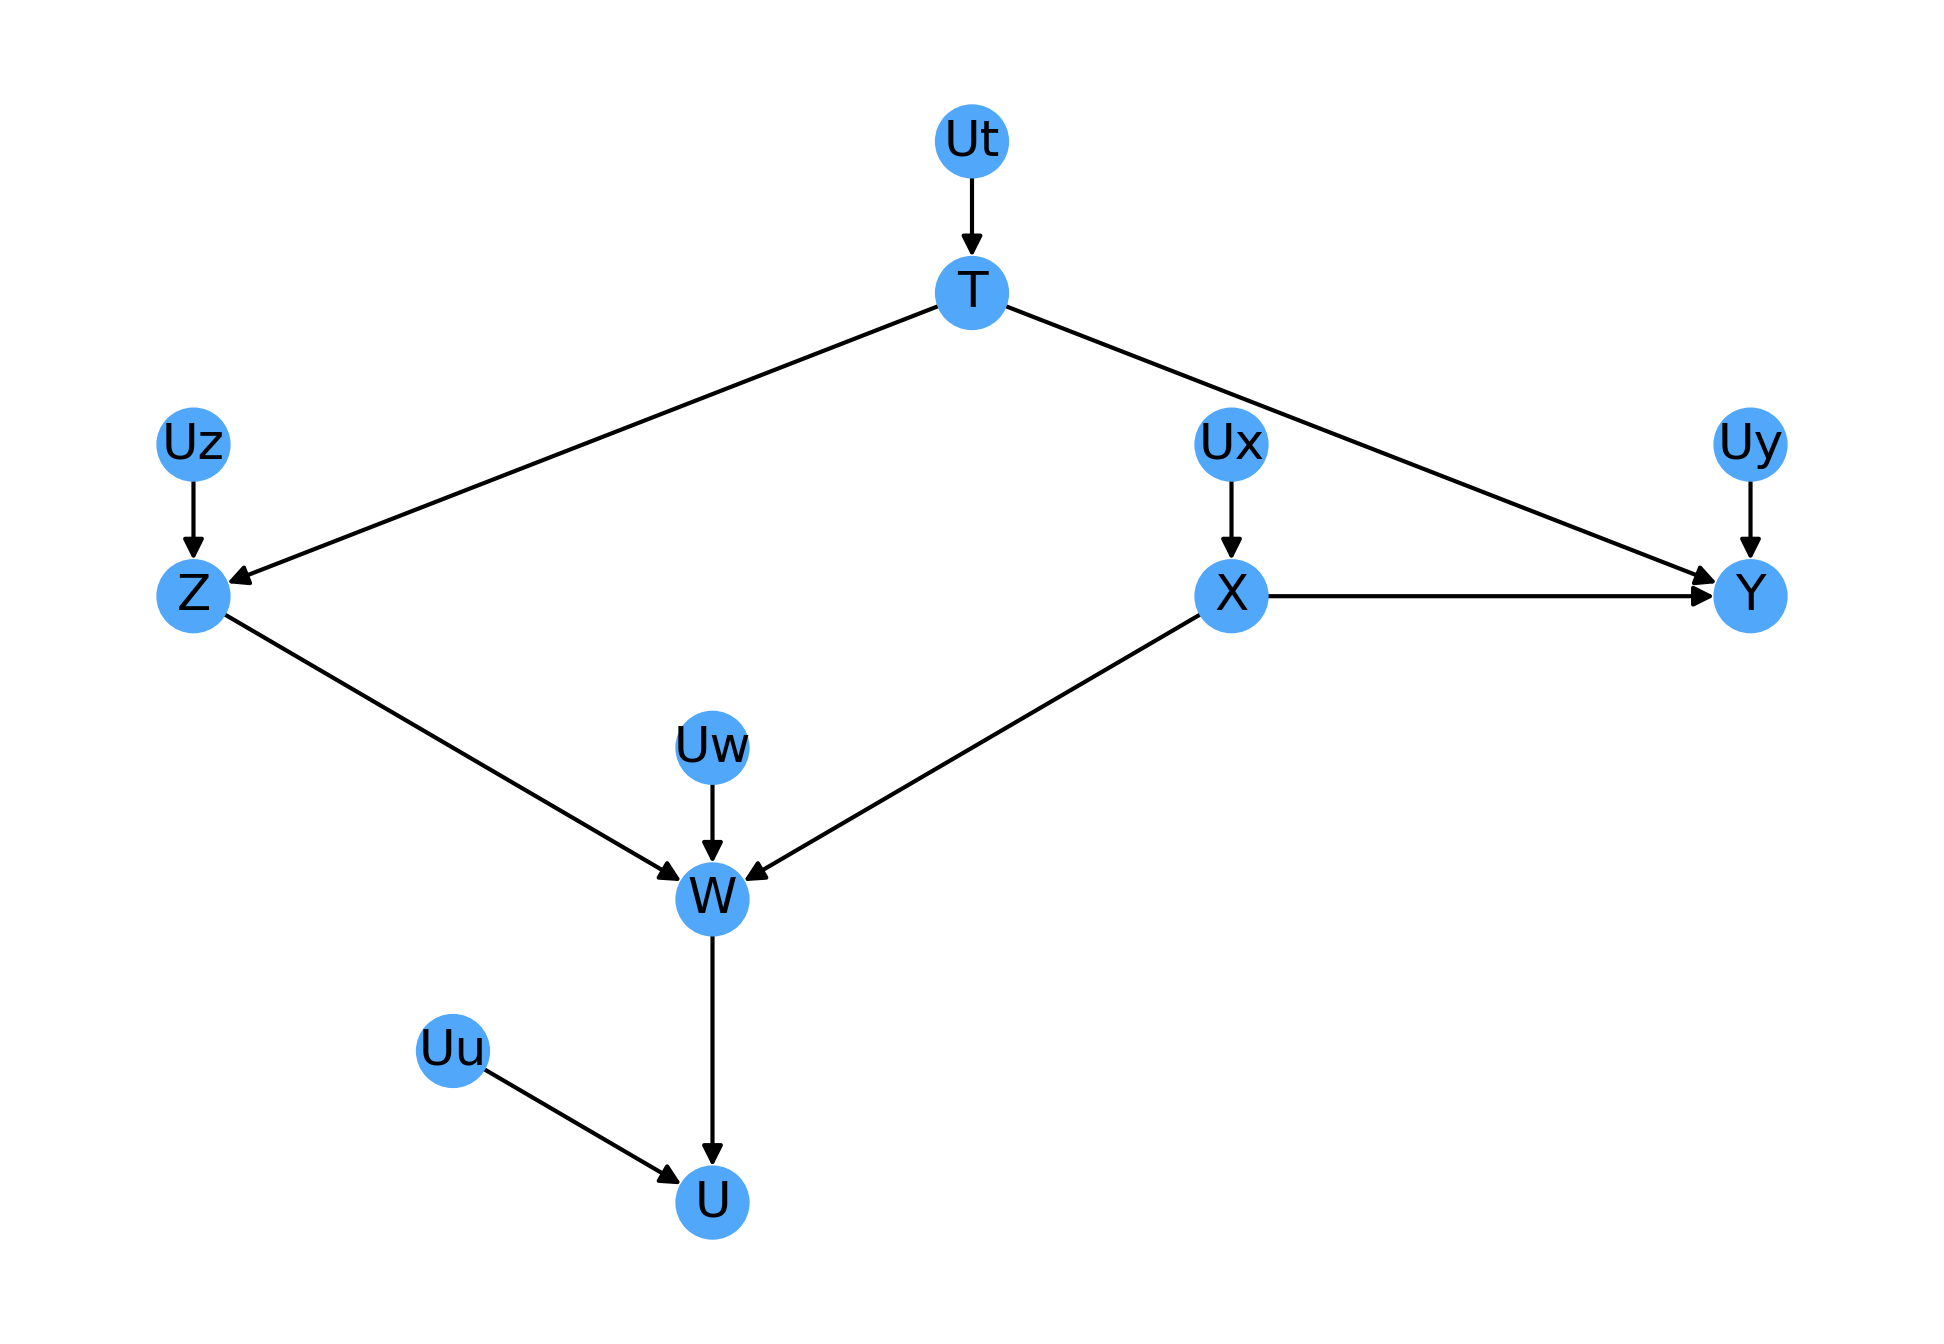

In [93]:
fig, ax = plt.subplots(1, figsize=(7, 5))
G.plot(ax=ax)

In [94]:
G.save_model('dags/Primer.Fig.2.8.dot')

And we can easily visualize both paths

In [95]:
path

('Z', 'W', 'X', 'Y')

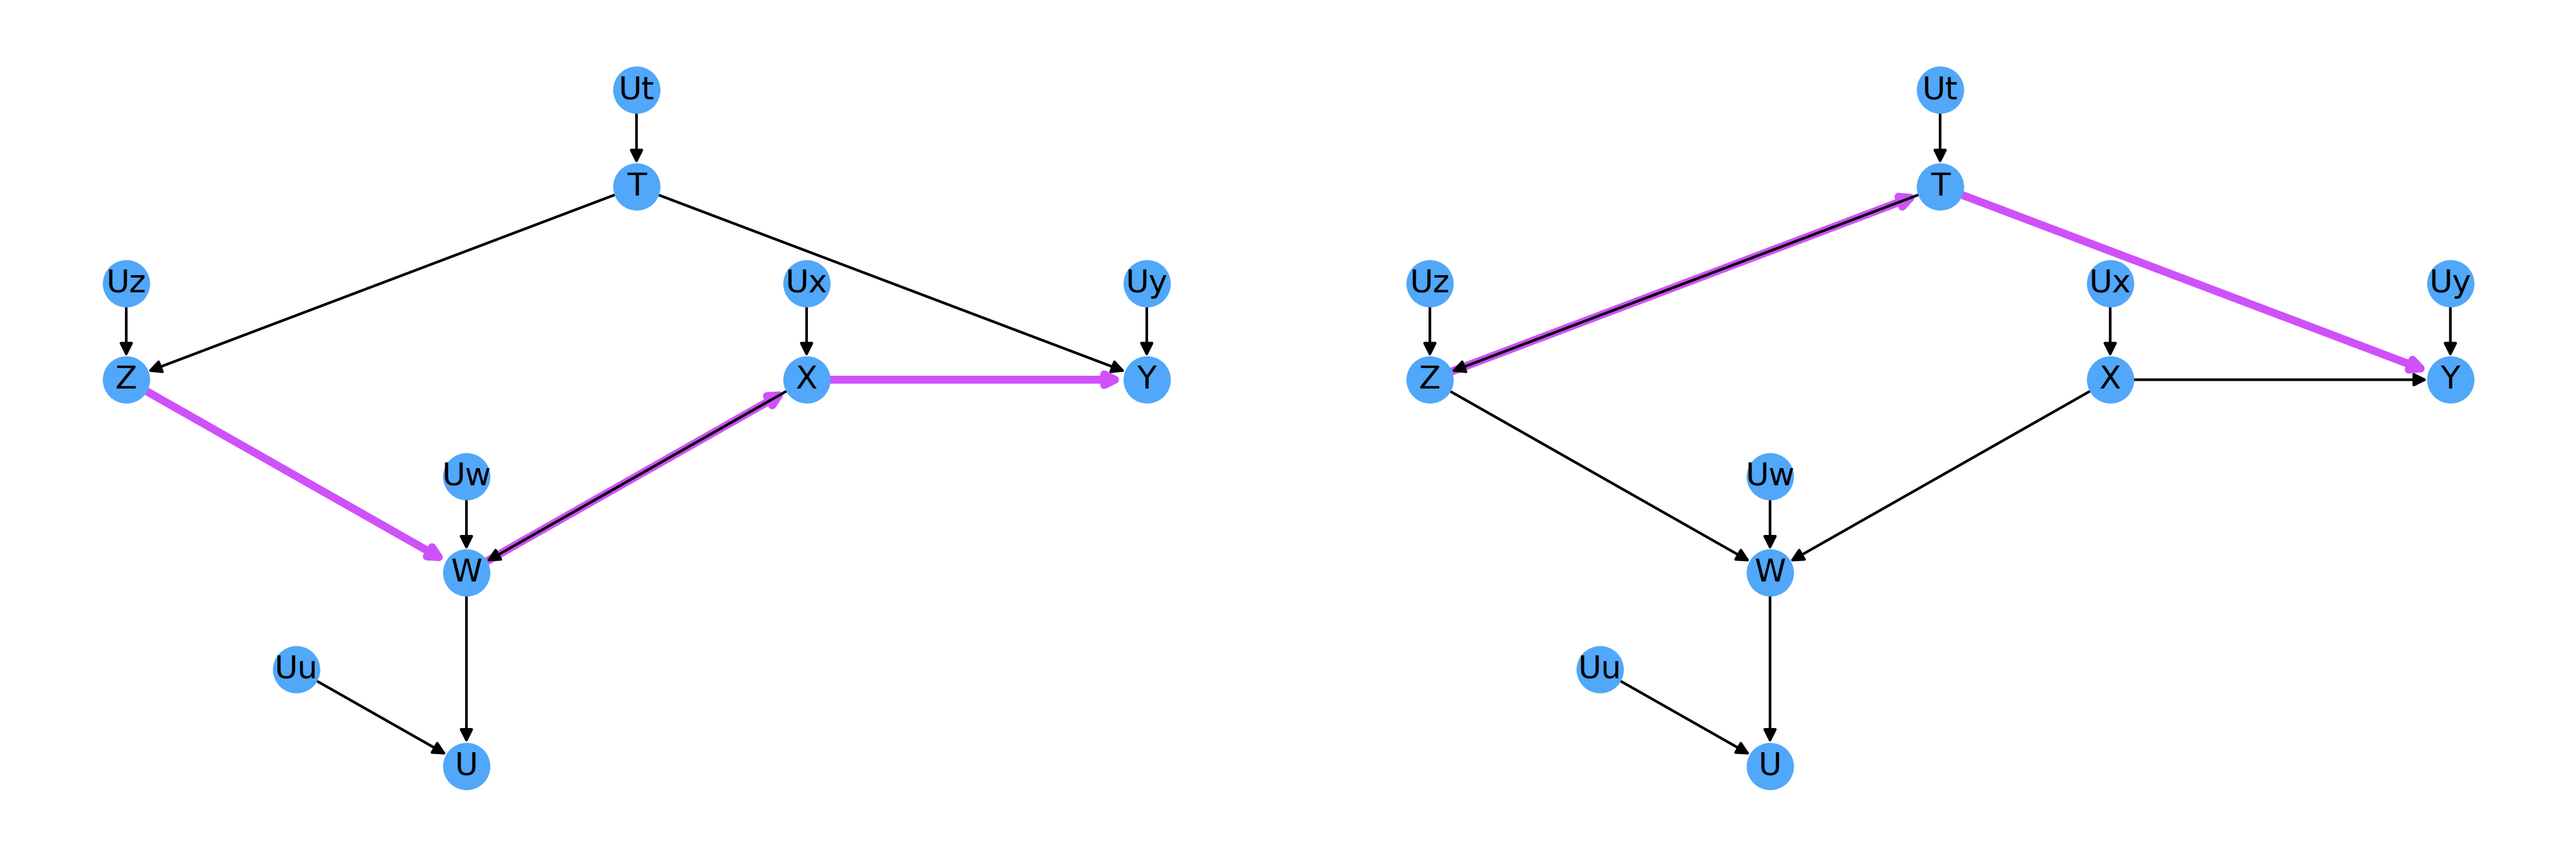

In [96]:
fig, ax_lst = plt.subplots(1, 2, figsize=(14, 5))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(list(G.all_paths('Z', 'Y'))[::-1]):
    G.plot_path(path, ax=ax_lst[i])

fig.tight_layout()

### Study question 2.4.1

In [97]:
G = CausalModel()
G.add_causation('Z1', 'Z3')
G.add_causation('Z1', 'X')
G.add_causation('Z2', 'Z3')
G.add_causation('Z2', 'Y')
G.add_causation('Z3', 'X')
G.add_causation('Z3', 'Y')
G.add_causation('X', 'W')
G.add_causation('W', 'Y')

G.pos = {'Z3':(0, 0), 'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'W':(0, -1), 'Y':(1, -1)}

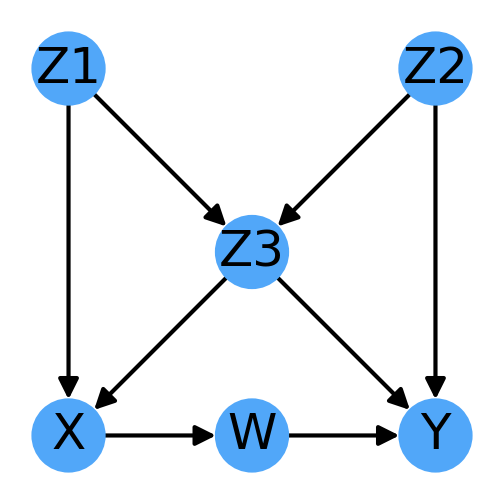

In [98]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G.plot(ax=ax)

In [99]:
G.save_model('dags/Primer.Fig.2.9.dot')

We have 5 total paths connecting X and Y

In [100]:
G.all_paths('X', 'Y')

{('X', 'W', 'Y'),
 ('X', 'Z1', 'Z3', 'Y'),
 ('X', 'Z1', 'Z3', 'Z2', 'Y'),
 ('X', 'Z3', 'Y'),
 ('X', 'Z3', 'Z2', 'Y')}

That we can visualize side by side

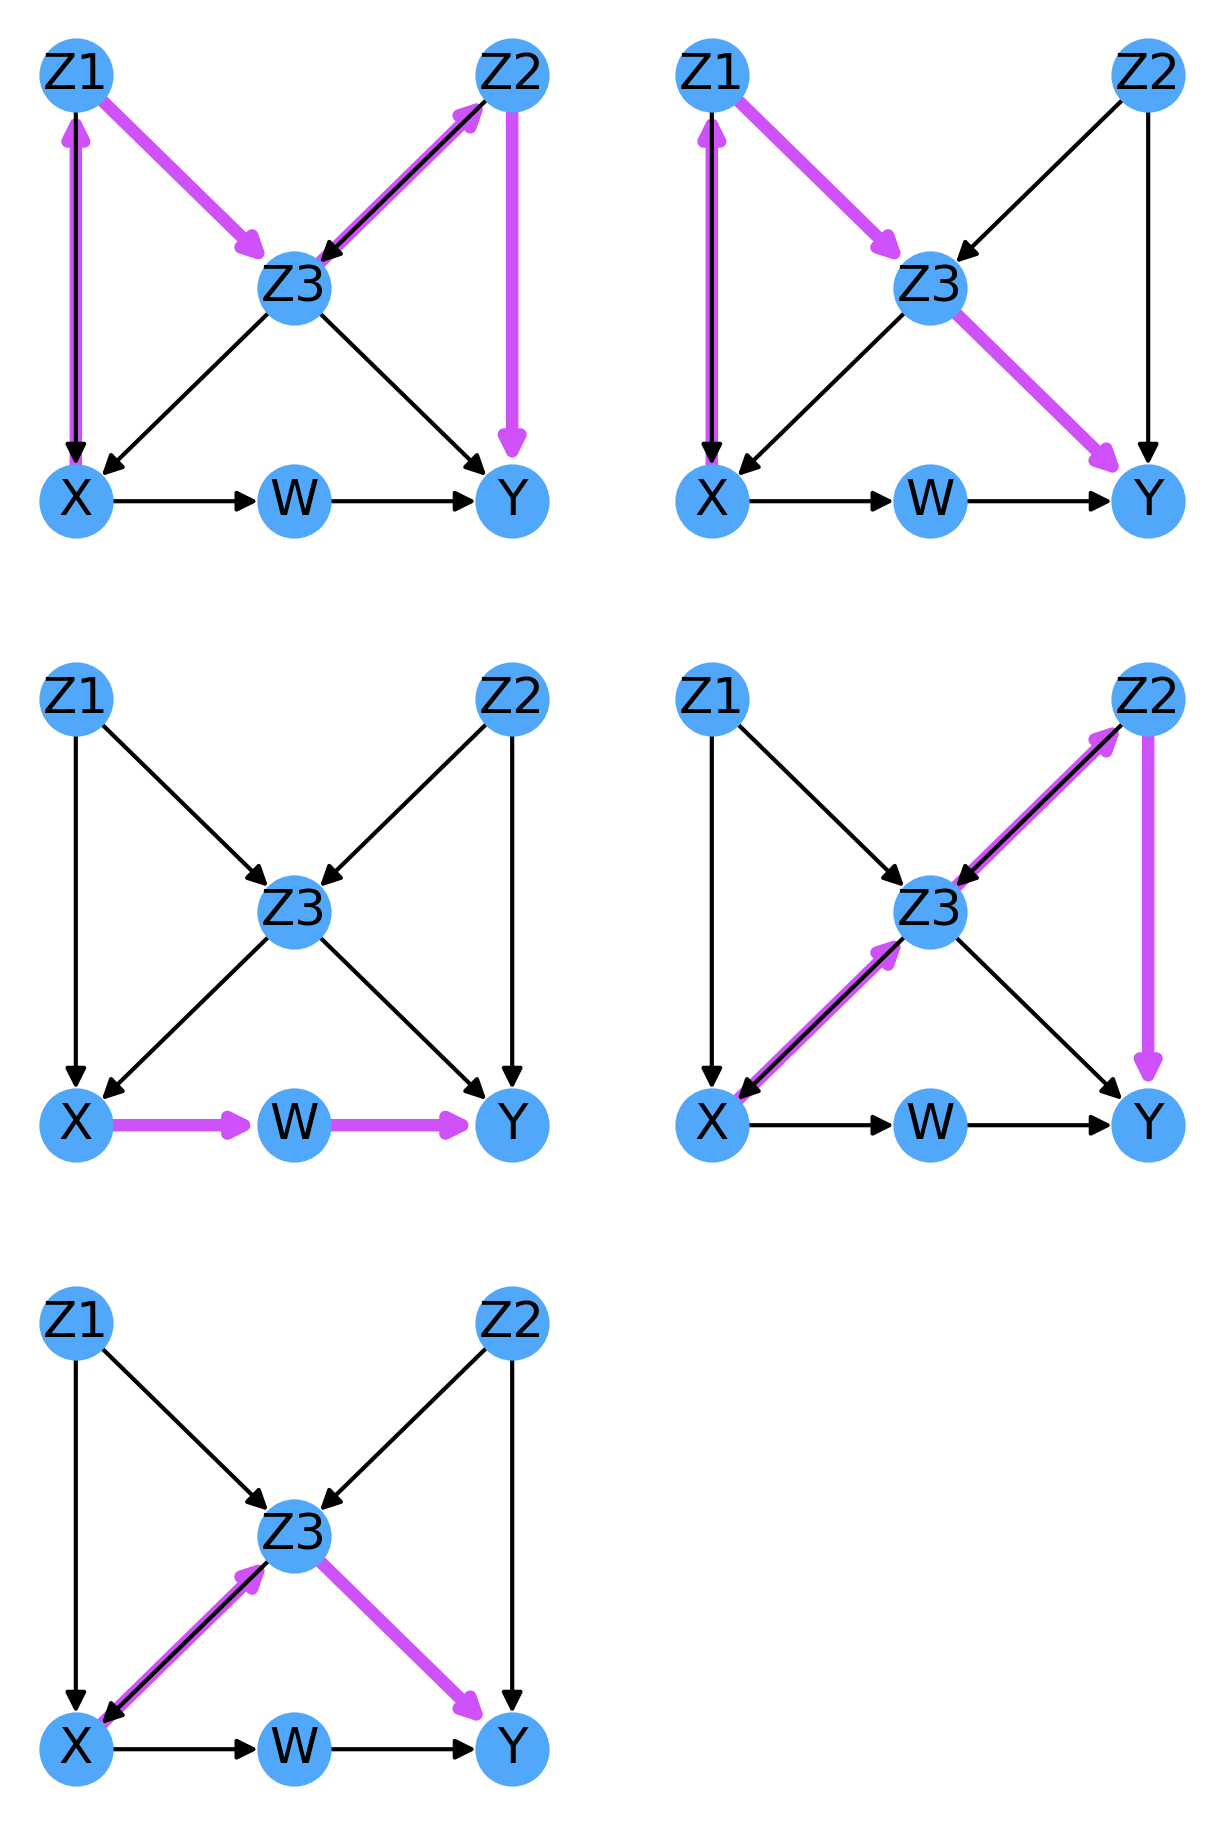

In [101]:
fig, ax_lst = plt.subplots(3, 2, figsize=(4.6, 6.6))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(G.all_paths('X', 'Y')):
    G.plot_path(path, ax=ax_lst[i])

ax_lst[-1].axis('off')
fig.tight_layout()

### Simulate the model

To verify our calculations we simulate the model using Gaussian distributed random numbers

In [102]:
N = 100_000
df = pd.DataFrame({'Z1': np.random.normal(0, 1, N), 
                   'Z2': np.random.normal(0, 1, N),})

df['Z3'] = df['Z1'] + df['Z2'] + np.random.normal(0, .1, N)
df['X'] =  df['Z1'] + df['Z3'] + np.random.normal(0, .1, N)
df['W'] =  df['X'] + np.random.normal(0, .1, N)
df['Y'] =  df['W'] +  df['Z3'] + df['Z2'] + np.random.normal(0, .1, N)

In [103]:
df

,Z1,Z2,Z3,X,W,Y
0,-0.274882,0.057815,-0.324382,-0.600431,-0.419085,-0.883206
1,-0.180760,-0.492619,-0.652623,-0.777881,-0.732947,-1.773704
2,0.214275,0.050134,0.075517,0.195266,0.164244,0.262850
3,0.598241,0.157944,0.545529,1.127271,1.177071,1.839832
4,0.331828,-1.310957,-0.997092,-0.771000,-0.631200,-3.070222
...,...,...,...,...,...,...
99995,-1.960745,-0.641916,-2.457442,-4.482778,-4.370150,-7.442678
99996,0.163844,-0.149657,0.003562,0.247235,0.119484,-0.115982
99997,-0.411254,0.466444,0.110044,-0.524288,-0.538270,0.089153
99998,-1.224890,-0.096233,-1.355280,-2.675783,-2.678528,-4.126355


And thest the conditional independence of X and Y

In [104]:
formula = 'X ~ 1 + Y + W + Z3 + Z2'

In [105]:
results = smf.ols(formula, df).fit()

In [106]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.897e+07
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:01:09   Log-Likelihood:             1.0882e+05
No. Observations:              100000   AIC:                        -2.176e+05
Df Residuals:                   99995   BIC:                        -2.176e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.000     -0.754      0.451      -0.001       0.000
Y             -0.0037      0.003     -1.429      0.153      -0.009       0.001
W              0.6724      0.003    226.284      0.000       0.667       0.678
Z3             0.6631      0.004    168.720      0.000       0.655       0.671
Z2            -0.3244      0.003   -108.595      0.000      -0.330      -0.319
==============================================================================
Omnibus:                        0.812   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.666   Jarque-Bera (JB):                0.822
Skew:                           0.003   Prob(JB):                        0.663
Kurtosis:                       2.987   Cond. No.                         100.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>